In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=aa27cba9e96d58296b1730ab76affe8c04e7018c977700b68dba780ffa555dde
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
import sklearn.svm as svm
import sklearn.naive_bayes as naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from pyspark.sql import SparkSession
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import json
import nltk
import string
import re


In [ ]:
spark = SparkSession.builder \
    .appName("BigData") \
    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [ ]:
sp_web = spark.read.csv("train_data.csv", header=True, inferSchema=True, multiLine=True, escape='"')
test_df = spark.read.csv("test_data.csv", header=True, inferSchema=True, multiLine=True, escape='"')

In [ ]:
sp_web= sp_web.union(test_df)
sp_web

url,webpageDescription,alchemy_category,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,embedRatio,framebased,frameTagRatio,domainLink,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id
http://www.polyvo...,"{""title"":""Join Po...",?,?,1.916666667,0.047619048,0.007936508,0.0,0.0,0.803797468,0.0,0,0.027777778,0,0.203161066,3.12,?,0,34,0,682,126,1,0.531746032,0.142857143,1,3711
http://www.youtub...,"{""body"":""Speed Ai...",?,?,1.257575758,0.141025641,0.0,0.0,0.0,1.142857143,0.1,0,0.015086207,0,0.16818907,13.1,?,0,12,0,3008,78,1,0.628205128,0.0,1,7222
http://www.musing...,"{""title"":""Chicken...",science_technology,0.386685,2.024,0.630350195,0.284046693,0.233463035,0.20233463,0.443408788,0.0,0,0.033935018,0,0.192651673,0.126582278,1,1,17,0,11008,257,5,0.46692607,0.0625,1,3964
http://www.thelit...,"{""title"":""Ikan Bi...",recreation,0.475039,1.665254237,0.41958042,0.199300699,0.097902098,0.066433566,0.472649047,0.0,0,0.03652968,0,0.198000059,0.13559322,1,1,28,0,4585,286,5,0.244755245,0.085867621,1,3697
http://recipes.wu...,"{""url"":""recipes w...",computer_internet,0.535009,0.181818182,0.036363636,0.0,0.0,0.0,0.292613636,0.0,0,0.015151515,0,0.241563622,0.054216867,?,0,3,0,1745,55,1,0.072727273,0.115044248,1,4321
http://www.sleepd...,"{""title"":""Discove...",health,0.953935,3.697916667,0.848484848,0.636363636,0.191919192,0.101010101,0.38258538,0.0,0,0.02244898,0,0.254479838,0.003398471,1,1,23,0,6061,99,16,0.01010101,0.105439331,1,6940
http://www.inside...,"{""title"":""Insider...",health,0.893828,1.691780822,0.469798658,0.147651007,0.026845638,0.006711409,0.522133939,0.0,0,0.026190476,0,0.264696599,0.045454545,?,0,57,0,961,149,4,0.006711409,0.086956522,1,5416
http://yawoot.com...,"{""title"":""Well th...",recreation,0.550131,1.170212766,0.634920635,0.0,0.0,0.0,0.224906065,0.0,0,0.040247678,0,0.181395581,0.011560694,?,0,11,0,1865,63,1,0.031746032,0.123209169,0,7349
http://www.bbc.co...,"{""url"":""bbc co ne...",computer_internet,0.537425,3.466666667,0.453703704,0.194444444,0.138888889,0.12962963,0.604118993,0.0,0,0.111581921,0,0.234397297,0.708860759,1,1,64,0,977,108,2,0.064814815,0.085106383,0,6727
http://fxcuisine....,"{""title"":""Sicilia...",computer_internet,0.287329,0.941176471,0.117647059,0.039215686,0.0,0.0,0.487411233,0.0,0,0.088785047,0,0.303561825,0.034482759,1,0,7,0,2625,51,5,0.705882353,0.094642857,1,5155


In [ ]:
from pyspark.sql import functions as F

null_counts = sp_web.agg(*[F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in sp_web.columns])
null_counts.show(vertical=True)

-RECORD 0--------------------------
 url                        | 0    
 webpageDescription         | 0    
 alchemy_category           | 0    
 alchemy_category_score     | 0    
 avgLinkWordLength          | 0    
 AvglinkWithOneCommonWord   | 0    
 AvglinkWithTwoCommonWord   | 0    
 AvglinkWithThreeCommonWord | 0    
 AvglinkWithFourCommonWord  | 0    
 redundancyMeasure          | 0    
 embedRatio                 | 0    
 framebased                 | 0    
 frameTagRatio              | 0    
 domainLink                 | 0    
 tagRatio                   | 0    
 imageTagRatio              | 0    
 isNews                     | 0    
 lengthyDomain              | 0    
 hyperlinkToAllWordsRatio   | 0    
 isFrontPageNews            | 0    
 alphanumCharCount          | 0    
 linksCount                 | 0    
 wordCount                  | 0    
 parametrizedLinkRatio      | 0    
 spellingErrorsRatio        | 0    
 label                      | 1479 
 id                         

In [ ]:
null_counts = sp_web.agg(*[F.sum(F.when(F.col(c) == '?', 1).otherwise(0)).alias(c) for c in sp_web.columns])
null_counts.show(vertical=True)

-RECORD 0--------------------------
 url                        | 0    
 webpageDescription         | 0    
 alchemy_category           | 2342 
 alchemy_category_score     | 2342 
 avgLinkWordLength          | 0    
 AvglinkWithOneCommonWord   | 0    
 AvglinkWithTwoCommonWord   | 0    
 AvglinkWithThreeCommonWord | 0    
 AvglinkWithFourCommonWord  | 0    
 redundancyMeasure          | 0    
 embedRatio                 | 0    
 framebased                 | 0    
 frameTagRatio              | 0    
 domainLink                 | 0    
 tagRatio                   | 0    
 imageTagRatio              | 0    
 isNews                     | 2843 
 lengthyDomain              | 0    
 hyperlinkToAllWordsRatio   | 0    
 isFrontPageNews            | 1248 
 alphanumCharCount          | 0    
 linksCount                 | 0    
 wordCount                  | 0    
 parametrizedLinkRatio      | 0    
 spellingErrorsRatio        | 0    
 label                      | 0    
 id                         

In [ ]:
value_counts = sp_web.groupBy("isNews").count().orderBy(F.desc("count"))

value_counts.show()


+------+-----+
|isNews|count|
+------+-----+
|     1| 4552|
|     ?| 2843|
+------+-----+



In [ ]:
from pyspark.sql.functions import when

sp_web= sp_web.withColumn("isNews",
                             when(sp_web["isNews"] == "?", 0).otherwise(sp_web["isNews"]))


In [ ]:
value_counts = sp_web.groupBy("isNews").count().orderBy(F.desc("count"))
value_counts.show()

+------+-----+
|isNews|count|
+------+-----+
|     1| 4552|
|     0| 2843|
+------+-----+



In [ ]:
value_counts = sp_web.groupBy("isFrontPageNews").count().orderBy(F.desc("count"))

value_counts.show()


+---------------+-----+
|isFrontPageNews|count|
+---------------+-----+
|              0| 5853|
|              ?| 1248|
|              1|  294|
+---------------+-----+



In [ ]:
from pyspark.sql.functions import when

sp_web = sp_web.withColumn("isFrontPageNews",
                             when(sp_web["isFrontPageNews"] == "?", 0).otherwise(sp_web["isFrontPageNews"]))


In [ ]:
value_counts = sp_web.groupBy("isFrontPageNews").count().orderBy(F.desc("count"))
value_counts.show()

+---------------+-----+
|isFrontPageNews|count|
+---------------+-----+
|              0| 7101|
|              1|  294|
+---------------+-----+



In [ ]:
value_counts = sp_web.groupBy("alchemy_category_score").count().orderBy(F.desc("count"))

value_counts.show()


+----------------------+-----+
|alchemy_category_score|count|
+----------------------+-----+
|                     ?| 2342|
|                  0.85|   82|
|             0.0784091|   40|
|              0.849999|   12|
|              0.535009|   10|
|               0.70677|    9|
|               0.33273|    7|
|               0.65146|    6|
|              0.400001|    6|
|              0.849997|    5|
|                   0.9|    5|
|                0.4875|    4|
|              0.849995|    3|
|              0.287329|    3|
|              0.899999|    3|
|              0.899997|    3|
|              0.722028|    3|
|              0.786501|    3|
|               0.25991|    3|
|              0.849994|    3|
+----------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import when, col, isnan, count

# 1. Replace '?' with null
sp_web = sp_web.withColumn("alchemy_category_score", when(col("alchemy_category_score") == '?', None).otherwise(col("alchemy_category_score")))

# 2. Convert the column to a numeric type
sp_web = sp_web.withColumn("alchemy_category_score", sp_web["alchemy_category_score"].cast("double"))

# 3. Describe the column to get summary statistics
sp_web.describe("alchemy_category_score").show()


+-------+----------------------+
|summary|alchemy_category_score|
+-------+----------------------+
|  count|                  5053|
|   mean|    0.6033343166237883|
| stddev|   0.21286385974141167|
|    min|             0.0708333|
|    max|              0.999426|
+-------+----------------------+



In [ ]:
import pandas as pd

column_data = sp_web.select("alchemy_category_score").na.drop().toPandas()["alchemy_category_score"]


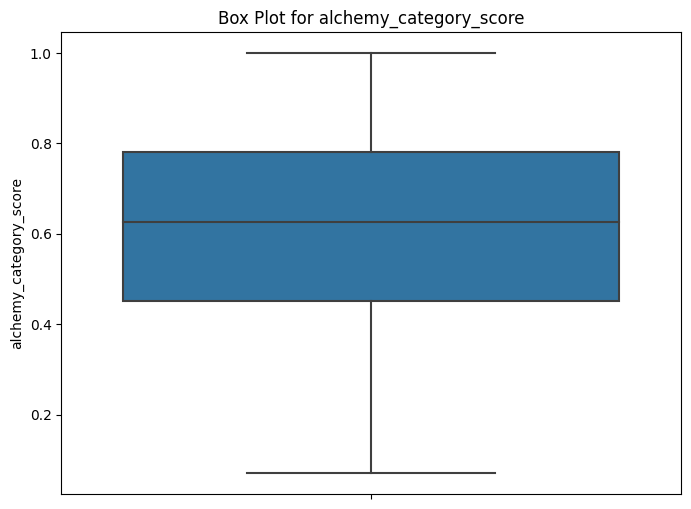

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(y=column_data)
plt.title('Box Plot for alchemy_category_score')
plt.show()


<ipython-input-18-7c8043332b1d>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(column_data, hist=True, kde=True,


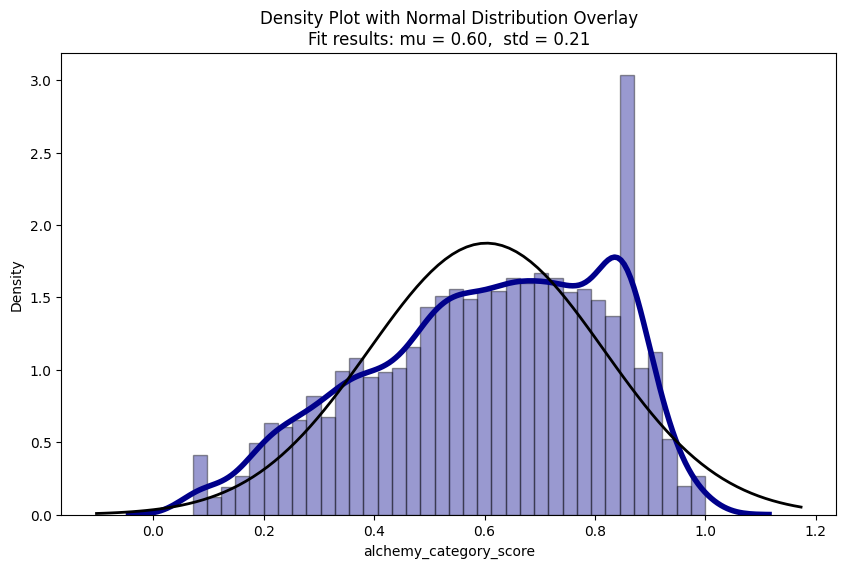

In [ ]:
import numpy as np
from scipy.stats import norm

plt.figure(figsize=(10, 6))

# Draw the histogram for the column data
sns.distplot(column_data, hist=True, kde=True,
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

# Overlay with normal distribution using mean and standard deviation of the data
mu, std = norm.fit(column_data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title('Density Plot with Normal Distribution Overlay\n' + title)
plt.xlabel('alchemy_category_score')
plt.ylabel('Density')
plt.show()


In [ ]:
from pyspark.sql.functions import avg, stddev, pow, count, sum as sum_col

# Calculate mean and standard deviation
mean_val = sp_web.agg(avg("alchemy_category_score")).collect()[0][0]
std_dev = sp_web.agg(stddev("alchemy_category_score")).collect()[0][0]
n = sp_web.agg(count("alchemy_category_score")).collect()[0][0]

# Compute skewness
skewness_formula = (n / ((n - 1) * (n - 2))) * sum_col(pow((col("alchemy_category_score") - mean_val) / std_dev, 3))

skewness = sp_web.agg(skewness_formula).collect()[0][0]

print("Skewness of alchemy_category_score:", skewness)


Skewness of alchemy_category_score: -0.4017610539150858


In [ ]:
from pyspark.sql.functions import mean, col

# Calculate mean of the alchemy_category_score column
mean_value = sp_web.agg(mean(col("alchemy_category_score"))).collect()[0][0]

# Fill missing values with the mean
sp_web = sp_web.withColumn("alchemy_category_score",
                             col("alchemy_category_score").cast("double")) # Ensure the column is of type double
sp_web = sp_web.na.fill({'alchemy_category_score': mean_value})

# Describe the column
sp_web.describe("alchemy_category_score").show()


+-------+----------------------+
|summary|alchemy_category_score|
+-------+----------------------+
|  count|                  7395|
|   mean|    0.6033343166237798|
| stddev|   0.17595186744428384|
|    min|             0.0708333|
|    max|              0.999426|
+-------+----------------------+



In [ ]:
value_counts = sp_web.groupBy("alchemy_category_score").count().orderBy(F.desc("count"))

value_counts.show()

+----------------------+-----+
|alchemy_category_score|count|
+----------------------+-----+
|    0.6033343166237883| 2342|
|                  0.85|   82|
|             0.0784091|   40|
|              0.849999|   12|
|              0.535009|   10|
|               0.70677|    9|
|               0.33273|    7|
|               0.65146|    6|
|              0.400001|    6|
|              0.849997|    5|
|                   0.9|    5|
|                0.4875|    4|
|              0.786501|    3|
|              0.287329|    3|
|              0.849994|    3|
|              0.899997|    3|
|               0.21965|    3|
|               0.25991|    3|
|              0.899999|    3|
|              0.849995|    3|
+----------------------+-----+
only showing top 20 rows



In [ ]:
value_counts = sp_web.groupBy("alchemy_category").count().orderBy(F.desc("count"))

value_counts.show()


+------------------+-----+
|  alchemy_category|count|
+------------------+-----+
|                 ?| 2342|
|        recreation| 1229|
|arts_entertainment|  941|
|          business|  880|
|            health|  506|
|            sports|  380|
|  culture_politics|  343|
| computer_internet|  296|
|science_technology|  289|
|            gaming|   76|
|          religion|   72|
|         law_crime|   31|
|           unknown|    6|
|           weather|    4|
+------------------+-----+



In [ ]:
from pyspark.sql.functions import when, col

sp_web = sp_web.withColumn("alchemy_category",
                             when(col("alchemy_category") == "?", "Nothing").otherwise(col("alchemy_category")))



In [ ]:
value_counts = sp_web.groupBy("alchemy_category").count().orderBy(F.desc("count"))

value_counts.show()

+------------------+-----+
|  alchemy_category|count|
+------------------+-----+
|           Nothing| 2342|
|        recreation| 1229|
|arts_entertainment|  941|
|          business|  880|
|            health|  506|
|            sports|  380|
|  culture_politics|  343|
| computer_internet|  296|
|science_technology|  289|
|            gaming|   76|
|          religion|   72|
|         law_crime|   31|
|           unknown|    6|
|           weather|    4|
+------------------+-----+



In [ ]:
value_counts = sp_web.groupBy("domainLink").count().orderBy(F.desc("count"))

value_counts.show()


+----------+-----+
|domainLink|count|
+----------+-----+
|         0| 7238|
|         1|  157|
+----------+-----+



In [ ]:
value_counts = sp_web.groupBy("framebased").count().orderBy(F.desc("count"))

value_counts.show()


+----------+-----+
|framebased|count|
+----------+-----+
|         0| 7395|
+----------+-----+



In [ ]:
columns_to_be_deleted = ["framebased", "domainLink"]
sp_web = sp_web.drop(*columns_to_be_deleted)
sp_web


url,webpageDescription,alchemy_category,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,embedRatio,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id
http://www.polyvo...,"{""title"":""Join Po...",Nothing,0.6033343166237883,1.916666667,0.047619048,0.007936508,0.0,0.0,0.803797468,0.0,0.027777778,0.203161066,3.12,0,0,34,0,682,126,1,0.531746032,0.142857143,1,3711
http://www.youtub...,"{""body"":""Speed Ai...",Nothing,0.6033343166237883,1.257575758,0.141025641,0.0,0.0,0.0,1.142857143,0.1,0.015086207,0.16818907,13.1,0,0,12,0,3008,78,1,0.628205128,0.0,1,7222
http://www.musing...,"{""title"":""Chicken...",science_technology,0.386685,2.024,0.630350195,0.284046693,0.233463035,0.20233463,0.443408788,0.0,0.033935018,0.192651673,0.126582278,1,1,17,0,11008,257,5,0.46692607,0.0625,1,3964
http://www.thelit...,"{""title"":""Ikan Bi...",recreation,0.475039,1.665254237,0.41958042,0.199300699,0.097902098,0.066433566,0.472649047,0.0,0.03652968,0.198000059,0.13559322,1,1,28,0,4585,286,5,0.244755245,0.085867621,1,3697
http://recipes.wu...,"{""url"":""recipes w...",computer_internet,0.535009,0.181818182,0.036363636,0.0,0.0,0.0,0.292613636,0.0,0.015151515,0.241563622,0.054216867,0,0,3,0,1745,55,1,0.072727273,0.115044248,1,4321
http://www.sleepd...,"{""title"":""Discove...",health,0.953935,3.697916667,0.848484848,0.636363636,0.191919192,0.101010101,0.38258538,0.0,0.02244898,0.254479838,0.003398471,1,1,23,0,6061,99,16,0.01010101,0.105439331,1,6940
http://www.inside...,"{""title"":""Insider...",health,0.893828,1.691780822,0.469798658,0.147651007,0.026845638,0.006711409,0.522133939,0.0,0.026190476,0.264696599,0.045454545,0,0,57,0,961,149,4,0.006711409,0.086956522,1,5416
http://yawoot.com...,"{""title"":""Well th...",recreation,0.550131,1.170212766,0.634920635,0.0,0.0,0.0,0.224906065,0.0,0.040247678,0.181395581,0.011560694,0,0,11,0,1865,63,1,0.031746032,0.123209169,0,7349
http://www.bbc.co...,"{""url"":""bbc co ne...",computer_internet,0.537425,3.466666667,0.453703704,0.194444444,0.138888889,0.12962963,0.604118993,0.0,0.111581921,0.234397297,0.708860759,1,1,64,0,977,108,2,0.064814815,0.085106383,0,6727
http://fxcuisine....,"{""title"":""Sicilia...",computer_internet,0.287329,0.941176471,0.117647059,0.039215686,0.0,0.0,0.487411233,0.0,0.088785047,0.303561825,0.034482759,1,0,7,0,2625,51,5,0.705882353,0.094642857,1,5155


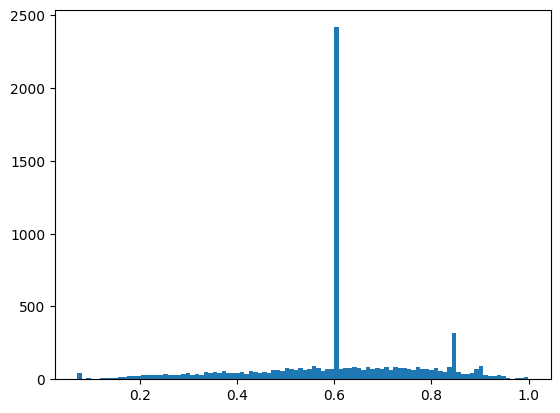

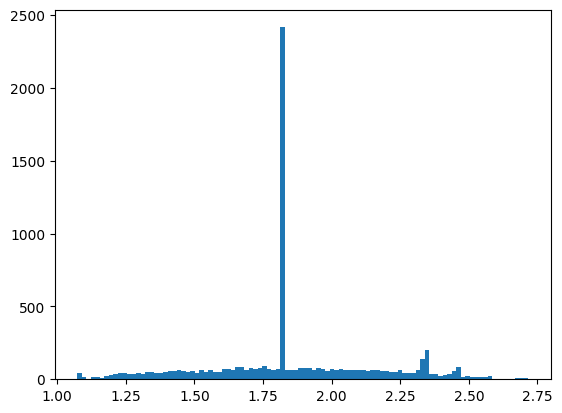

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, exp

# Convert the PySpark DataFrame column to a pandas DataFrame
alchemy_category_score_pd = sp_web.select("alchemy_category_score").toPandas()

# Plot the histogram for the original data
plt.hist(alchemy_category_score_pd["alchemy_category_score"].dropna(), bins=100)
plt.show()

# Apply the exponential transformation using numpy
transformed_scores = np.exp(alchemy_category_score_pd["alchemy_category_score"].dropna())

# Plot the histogram for the transformed data
plt.hist(transformed_scores, bins=100)
plt.show()



In [ ]:
# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("alchemy_category_score", exp(col("alchemy_category_score")))


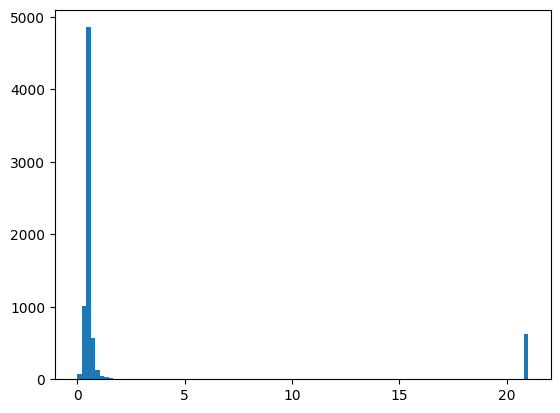

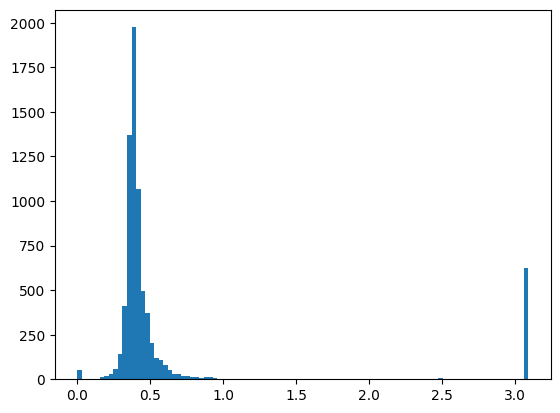

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log1p

# Convert the PySpark DataFrame column to a pandas DataFrame
redundancy_measure_pd = sp_web.select("redundancyMeasure").toPandas()

# Plot the histogram for the original data
plt.hist(redundancy_measure_pd["redundancyMeasure"].dropna(), bins=100)
plt.show()

# Apply the log transformation using numpy
transformed_redundancy = np.log(redundancy_measure_pd["redundancyMeasure"].dropna() + 1)

# Plot the histogram for the transformed data
plt.hist(transformed_redundancy, bins=100)
plt.show()


In [ ]:
# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("redundancyMeasure", log1p(col("redundancyMeasure")))

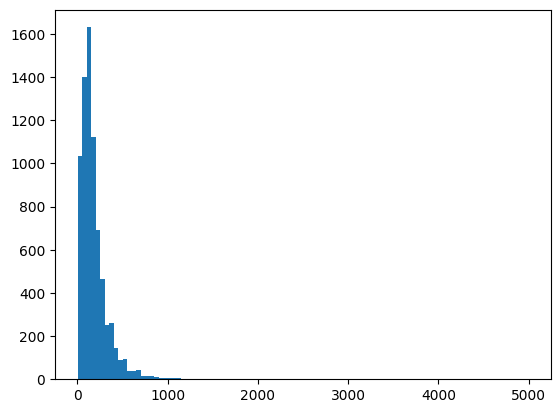

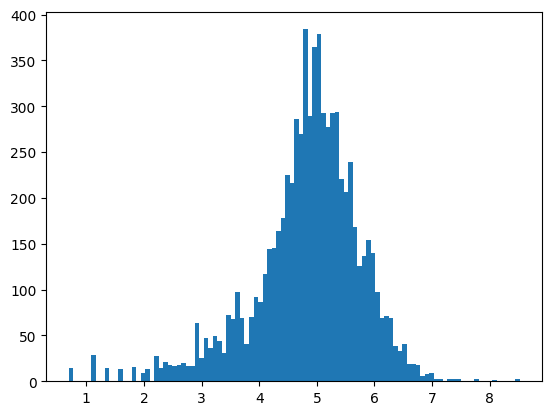

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log1p

# Convert the PySpark DataFrame column to a pandas DataFrame
links_count_pd = sp_web.select("linksCount").toPandas()

# Plot the histogram for the original data
plt.hist(links_count_pd["linksCount"].dropna(), bins=100)
plt.show()

# Apply the log1p transformation using numpy
transformed_links_count = np.log1p(links_count_pd["linksCount"].dropna())

# Plot the histogram for the transformed data
plt.hist(transformed_links_count, bins=100)
plt.show()



In [ ]:
# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("linksCount", log1p(col("linksCount")))

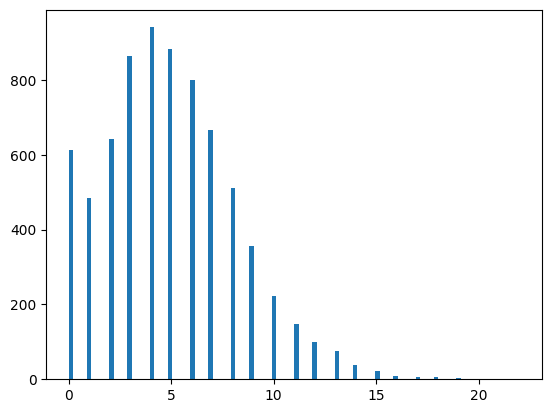

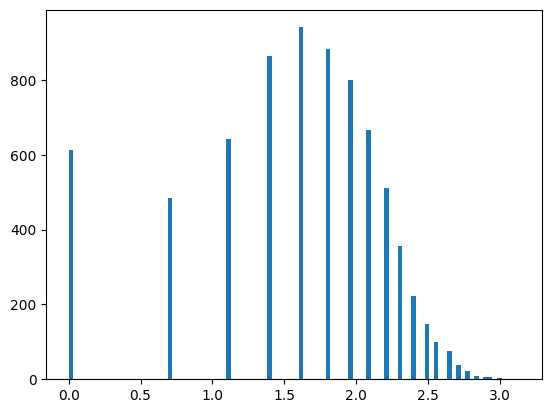

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log1p

# Convert the PySpark DataFrame column to a pandas DataFrame
word_count_pd = sp_web.select("wordCount").toPandas()

# Plot the histogram for the original data
plt.hist(word_count_pd["wordCount"].dropna(), bins=100)
plt.show()

# Apply the log1p transformation using numpy
transformed_word_count = np.log1p(word_count_pd["wordCount"].dropna())

# Plot the histogram for the transformed data
plt.hist(transformed_word_count, bins=100)
plt.show()

# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("wordCount", log1p(col("wordCount")))


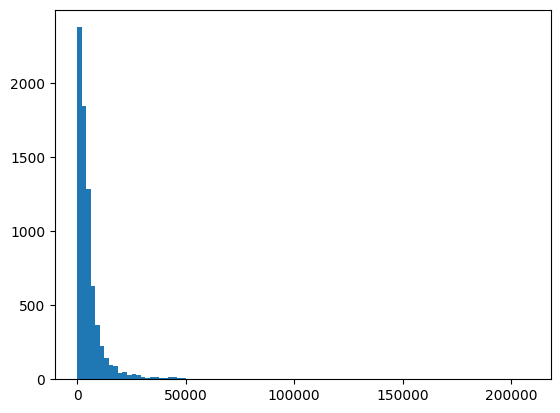

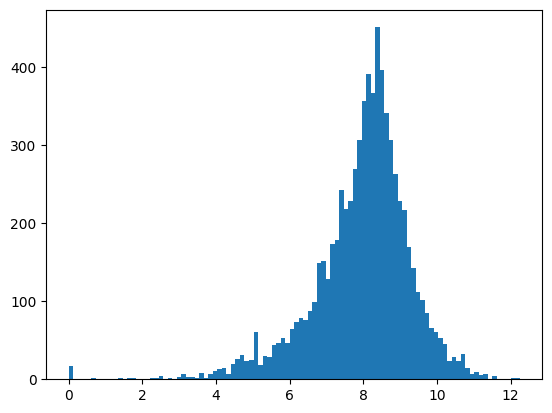

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log1p

# Convert the PySpark DataFrame column to a pandas DataFrame
alphanum_char_count_pd = sp_web.select("alphanumCharCount").toPandas()

# Plot the histogram for the original data
plt.hist(alphanum_char_count_pd["alphanumCharCount"].dropna(), bins=100)
plt.show()

# Apply the log1p transformation using numpy
transformed_alphanum_char_count = np.log1p(alphanum_char_count_pd["alphanumCharCount"].dropna())

# Plot the histogram for the transformed data
plt.hist(transformed_alphanum_char_count, bins=100)
plt.show()

# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("alphanumCharCount", log1p(col("alphanumCharCount")))


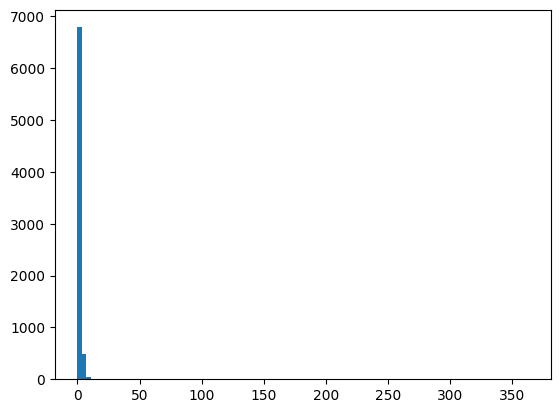

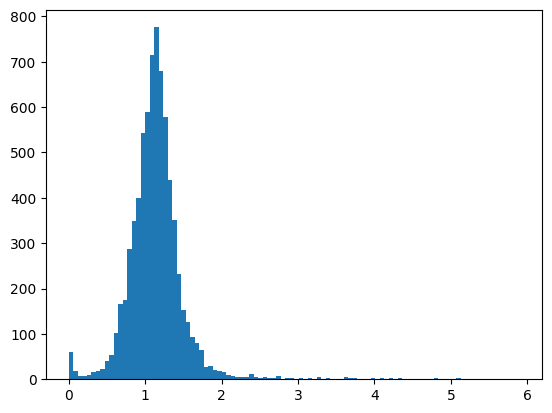

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log1p

# Convert the PySpark DataFrame column to a pandas DataFrame
avg_link_word_length_pd = sp_web.select("avgLinkWordLength").toPandas()

# Plot the histogram for the original data
plt.hist(avg_link_word_length_pd["avgLinkWordLength"].dropna(), bins=100)
plt.show()

# Apply the log1p transformation using numpy
transformed_avg_link_word_length = np.log1p(avg_link_word_length_pd["avgLinkWordLength"].dropna())

# Plot the histogram for the transformed data
plt.hist(transformed_avg_link_word_length, bins=100)
plt.show()

# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("avgLinkWordLength", log1p(col("avgLinkWordLength")))


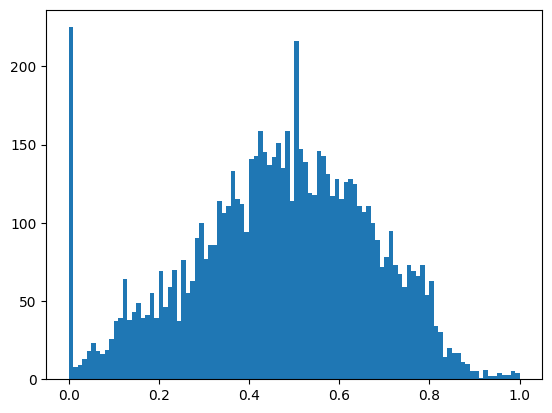

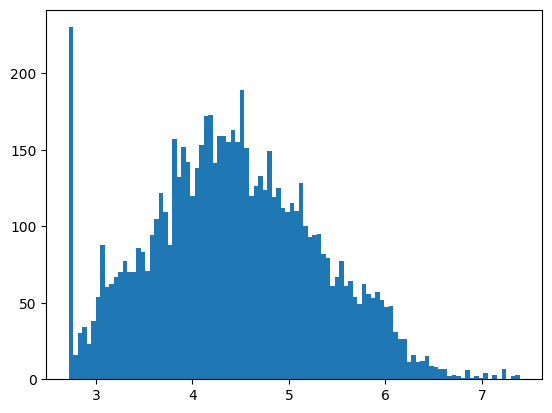

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, exp

# Convert the PySpark DataFrame column to a pandas DataFrame
avg_link_pd = sp_web.select("AvglinkWithOneCommonWord").toPandas()

# Plot the histogram for the original data
plt.hist(avg_link_pd["AvglinkWithOneCommonWord"].dropna(), bins=100)
plt.show()

# Apply the exponential transformation using numpy
transformed_avg_link = np.exp(avg_link_pd["AvglinkWithOneCommonWord"].dropna() + 1)

# Plot the histogram for the transformed data
plt.hist(transformed_avg_link, bins=100)
plt.show()

# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("AvglinkWithOneCommonWord", exp(col("AvglinkWithOneCommonWord") + 1))


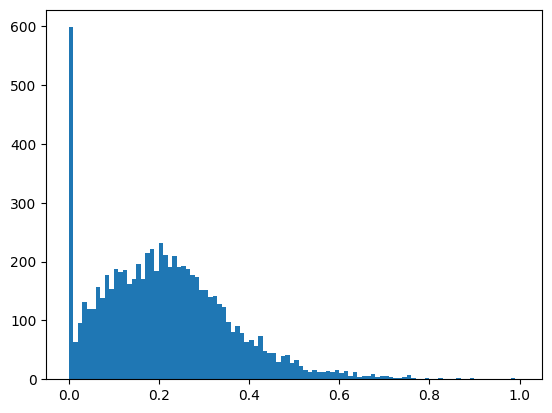

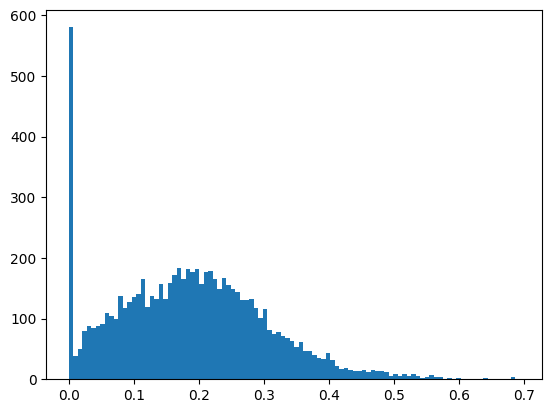

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log1p

# Convert the PySpark DataFrame column to a pandas DataFrame
avg_link_pd = sp_web.select("AvglinkWithTwoCommonWord").toPandas()

# Plot the histogram for the original data
plt.hist(avg_link_pd["AvglinkWithTwoCommonWord"].dropna(), bins=100)
plt.show()

# Apply the log1p transformation using numpy
transformed_avg_link = np.log1p(avg_link_pd["AvglinkWithTwoCommonWord"].dropna())

# Plot the histogram for the transformed data
plt.hist(transformed_avg_link, bins=100)
plt.show()

# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("AvglinkWithTwoCommonWord", log1p(col("AvglinkWithTwoCommonWord")))


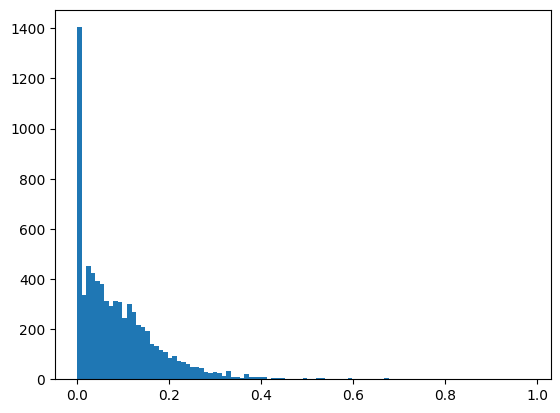

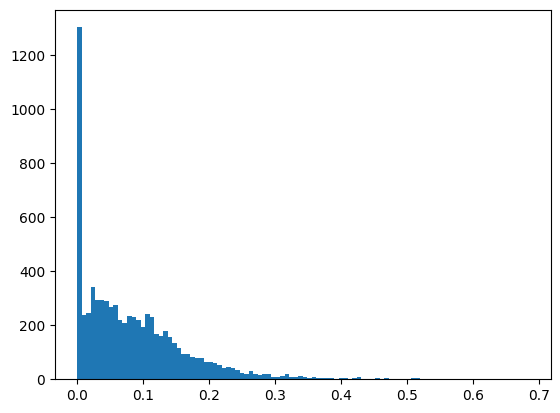

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log1p

# Convert the PySpark DataFrame column to a pandas DataFrame
avg_link_pd = sp_web.select("AvglinkWithThreeCommonWord").toPandas()

# Plot the histogram for the original data
plt.hist(avg_link_pd["AvglinkWithThreeCommonWord"].dropna(), bins=100)
plt.show()

# Apply the log1p transformation using numpy
transformed_avg_link = np.log1p(avg_link_pd["AvglinkWithThreeCommonWord"].dropna())

# Plot the histogram for the transformed data
plt.hist(transformed_avg_link, bins=100)
plt.show()

# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("AvglinkWithThreeCommonWord", log1p(col("AvglinkWithThreeCommonWord")))


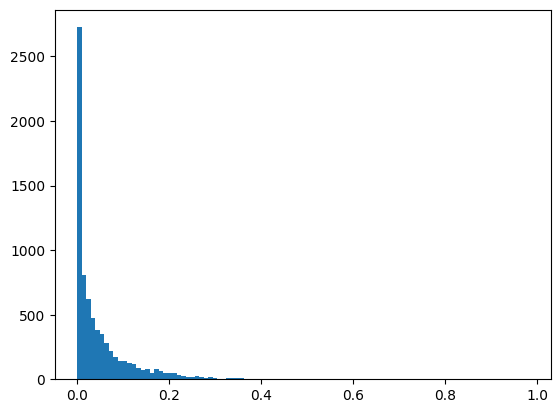

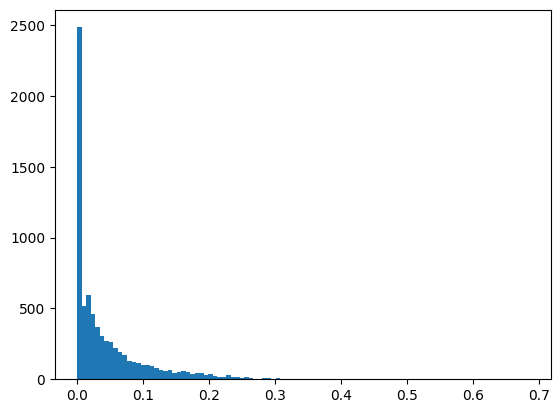

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, log1p

# Convert the PySpark DataFrame column to a pandas DataFrame
avg_link_pd = sp_web.select("AvglinkWithFourCommonWord").toPandas()

# Plot the histogram for the original data
plt.hist(avg_link_pd["AvglinkWithFourCommonWord"].dropna(), bins=100)
plt.show()

# Apply the log1p transformation using numpy
transformed_avg_link = np.log1p(avg_link_pd["AvglinkWithFourCommonWord"].dropna())

# Plot the histogram for the transformed data
plt.hist(transformed_avg_link, bins=100)
plt.show()

# Update the PySpark DataFrame with the transformed values
sp_web = sp_web.withColumn("AvglinkWithFourCommonWord", log1p(col("AvglinkWithFourCommonWord")))


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt

class OutlierRemoval:
    def __init__(self, lower_quartile, upper_quartile):
        self.lower_whisker = lower_quartile - 1.5*(upper_quartile - lower_quartile)
        self.upper_whisker = upper_quartile + 1.5*(upper_quartile - lower_quartile)

    def removeOutlier(self, x):
        return (x if x <= self.upper_whisker and x >= self.lower_whisker else (self.lower_whisker if x < self.lower_whisker else self.upper_whisker))

# Create a UDF based on the removeOutlier method
def create_outlier_udf(lower_quartile, upper_quartile):
    outlier_removal = OutlierRemoval(lower_quartile, upper_quartile)
    return udf(outlier_removal.removeOutlier, DoubleType())


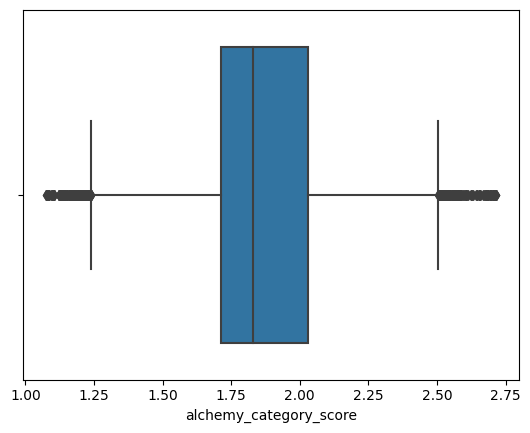

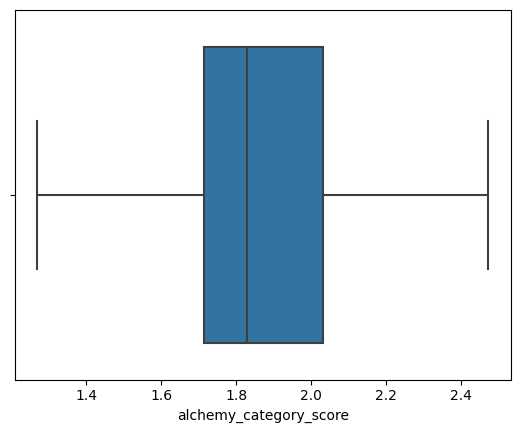

In [ ]:
# Assuming you have a DataFrame sp_web and a column "alchemy_category_score" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("alchemy_category_score", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("alchemy_category_score").toPandas()["alchemy_category_score"])
plt.show()

# Apply the UDF to remove outliers
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("alchemy_category_score", outlier_udf("alchemy_category_score"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("alchemy_category_score").toPandas()["alchemy_category_score"])
plt.show()

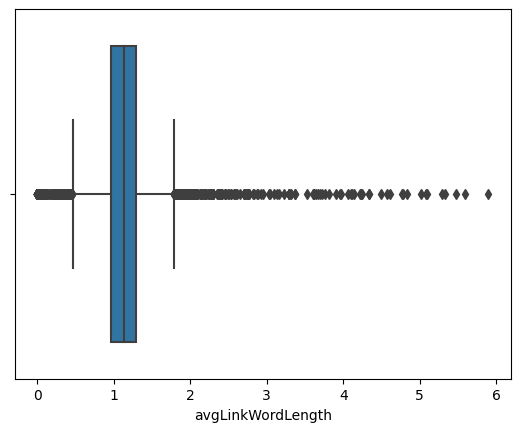

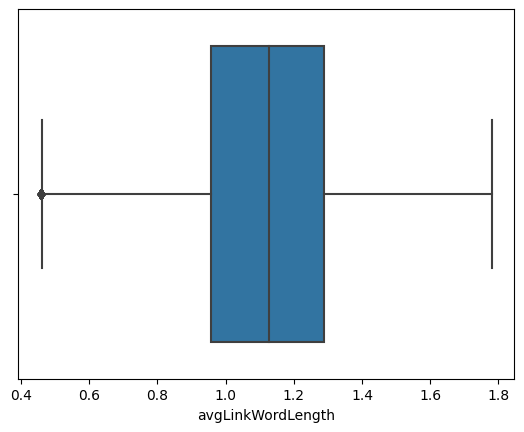

In [ ]:
# Assuming you have a DataFrame sp_web and a column "avgLinkWordLength" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("avgLinkWordLength", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("avgLinkWordLength").toPandas()["avgLinkWordLength"])
plt.show()

# Apply the UDF to remove outliers
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("avgLinkWordLength", outlier_udf("avgLinkWordLength"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("avgLinkWordLength").toPandas()["avgLinkWordLength"])
plt.show()

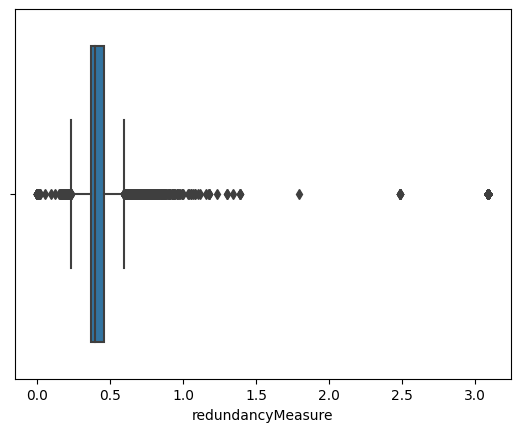

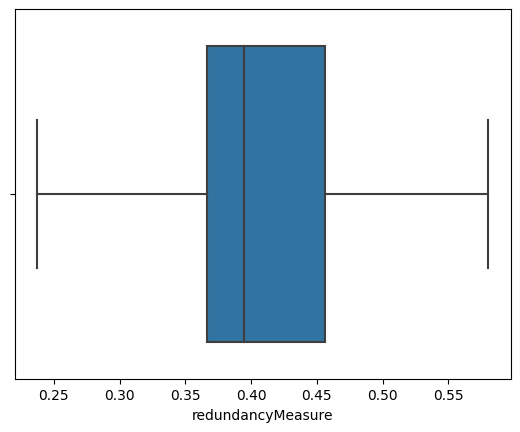

In [ ]:
# Assuming you have a DataFrame sp_web and a column "redundancyMeasure" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("redundancyMeasure", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("redundancyMeasure").toPandas()["redundancyMeasure"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("redundancyMeasure", outlier_udf("redundancyMeasure"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("redundancyMeasure").toPandas()["redundancyMeasure"])
plt.show()

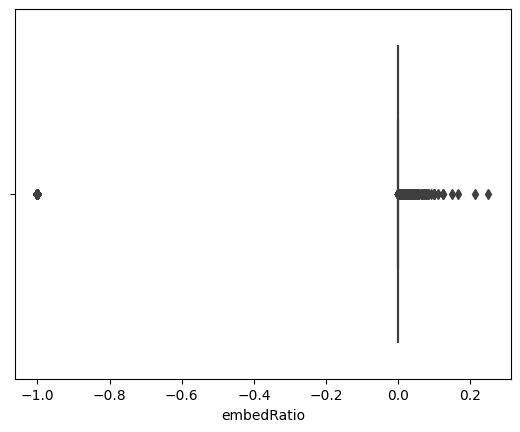

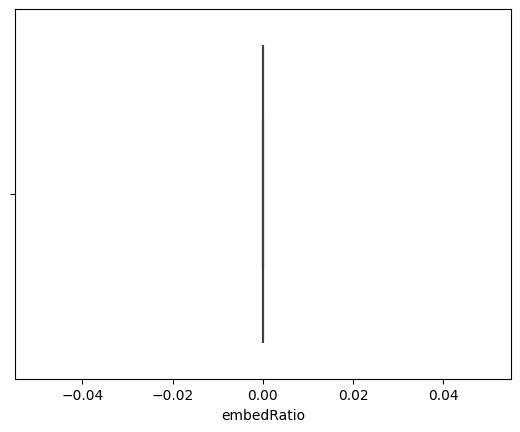

In [ ]:
# Assuming you have a DataFrame sp_web and a column "embedRatio" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("embedRatio", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("embedRatio").toPandas()["embedRatio"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("embedRatio", outlier_udf("embedRatio"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("embedRatio").toPandas()["embedRatio"])
plt.show()

In [ ]:
sp_web = sp_web.drop("embedRatio")
sp_web

url,webpageDescription,alchemy_category,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id
http://www.polyvo...,"{""title"":""Join Po...",Nothing,1.8282044615195077,1.070441411815699,2.8508552814091734,0.007905179570105402,0.0,0.0,0.5803887359324178,0.027777778,0.203161066,3.12,0,0,34,0,6.52649485957079,4.844187086458591,0.6931471805599453,0.531746032,0.142857143,1,3711
http://www.youtub...,"{""body"":""Speed Ai...",Nothing,1.8282044615195077,0.814291564106953,3.129976952166903,0.0,0.0,0.0,0.5803887359324178,0.015086207,0.16818907,13.1,0,0,12,0,8.009363076630045,4.3694478524670215,0.6931471805599453,0.628205128,0.0,1,7222
http://www.musing...,"{""title"":""Chicken...",science_technology,1.472092709027923,1.1065804583172865,5.105662382941083,0.2500165698713667,0.20982568896628795,0.18426519171126352,0.36700753003988484,0.033935018,0.192651673,0.126582278,1,1,17,0,9.306468399070404,5.552959584921617,1.791759469228055,0.46692607,0.0625,1,3964
http://www.thelit...,"{""title"":""Ikan Bi...",recreation,1.6080769112623954,0.9802994515667224,4.135384951370745,0.18173863609535845,0.09340117517757276,0.06431996538100165,0.3870628517946828,0.03652968,0.198000059,0.13559322,1,1,28,0,8.43076346341785,5.659482215759621,1.791759469228055,0.244755245,0.085867621,1,3697
http://recipes.wu...,"{""url"":""recipes w...",computer_internet,1.7074636093575437,0.45781950897976,2.8189476343703377,0.0,0.0,0.0,0.2566662430715346,0.015151515,0.241563622,0.054216867,0,0,3,0,7.465082736399547,4.02535169073515,0.6931471805599453,0.072727273,0.115044248,1,4321
http://www.sleepd...,"{""title"":""Discove...",health,2.47219462302148,1.5471191481057955,6.350190725720006,0.49247648487557194,0.17556477439887144,0.09622803208537947,0.32395521019277806,0.02244898,0.254479838,0.003398471,1,1,23,0,8.709795057617749,4.605170185988092,2.833213344056216,0.01010101,0.105439331,1,6940
http://www.inside...,"{""title"":""Insider...",health,2.4444691920712582,0.9902029901914591,4.3483595455110065,0.1377172508086627,0.02649161585220508,0.006688987757463276,0.4201132575386385,0.026190476,0.264696599,0.045454545,0,0,57,0,6.8690144506657065,5.0106352940962555,1.6094379124341003,0.006711409,0.086956522,1,5416
http://yawoot.com...,"{""title"":""Well th...",recreation,1.7334800888855628,0.7748252115938203,5.1290509137475215,0.0,0.0,0.0,0.23744858229494328,0.040247678,0.181395581,0.011560694,0,0,11,0,7.531552381407289,4.1588830833596715,0.6931471805599453,0.031746032,0.123209169,0,7349
http://www.bbc.co...,"{""url"":""bbc co ne...",computer_internet,1.7115938287337313,1.4966424183633829,4.278933105055906,0.1776811768653594,0.13005312834575877,0.12188981793690572,0.47257469185483447,0.111581921,0.234397297,0.708860759,1,1,64,0,6.885509670034818,4.6913478822291435,1.0986122886681096,0.064814815,0.085106383,0,6727
http://fxcuisine....,"{""title"":""Sicilia...",computer_internet,1.3328626531612828,0.6632942176223854,3.0576512595530314,0.03846628056364512,0.0,0.0,0.3970371813628889,0.088785047,0.303561825,0.034482759,1,0,7,0,7.873217054862741,3.9512437185814275,1.791759469228055,0.705882353,0.094642857,1,5155


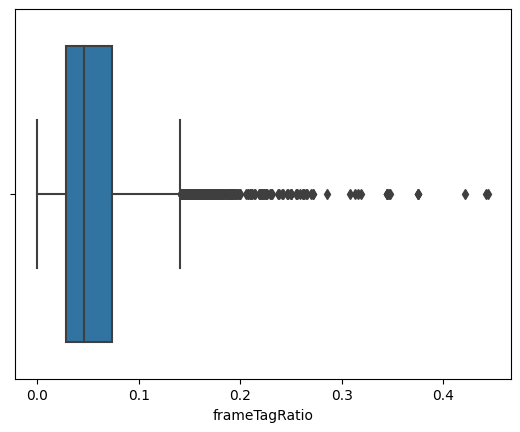

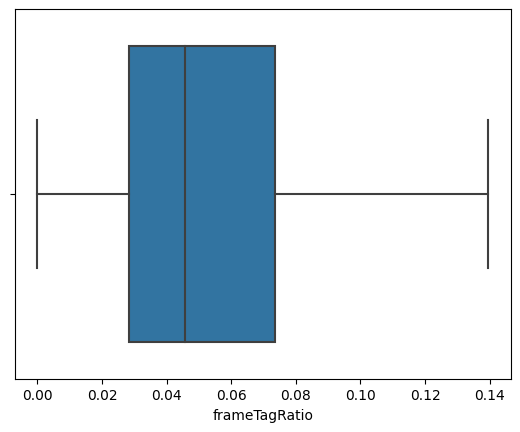

In [ ]:
# Assuming you have a DataFrame sp_web and a column "frameTagRatio" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("frameTagRatio", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("frameTagRatio").toPandas()["frameTagRatio"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("frameTagRatio", outlier_udf("frameTagRatio"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("frameTagRatio").toPandas()["frameTagRatio"])
plt.show()

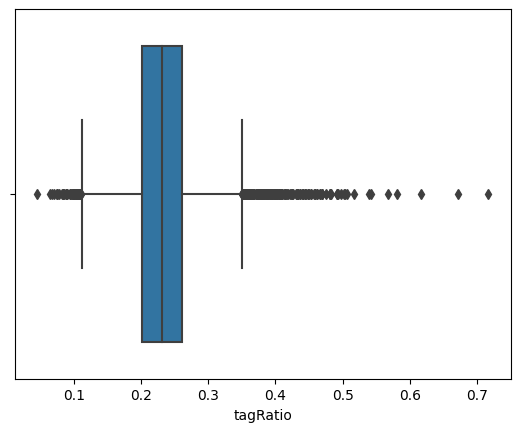

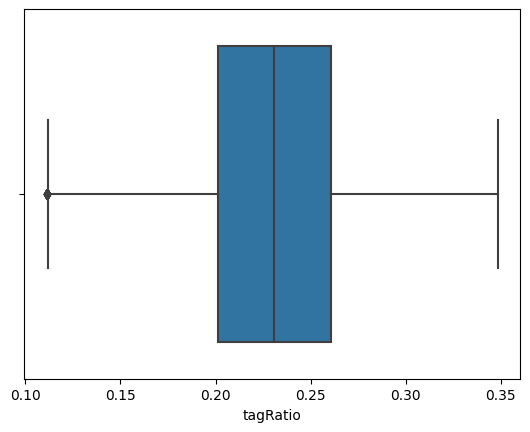

In [ ]:
# Assuming you have a DataFrame sp_web and a column "tagRatio" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("tagRatio", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("tagRatio").toPandas()["tagRatio"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("tagRatio", outlier_udf("tagRatio"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("tagRatio").toPandas()["tagRatio"])
plt.show()

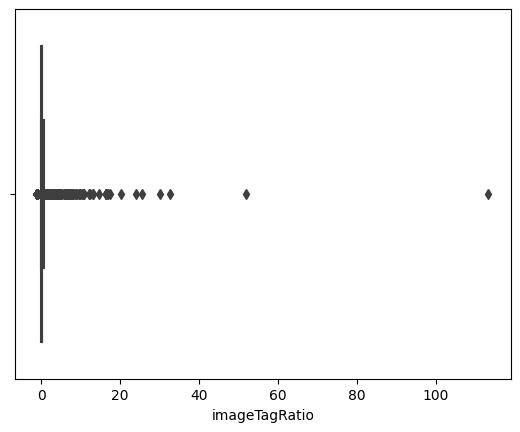

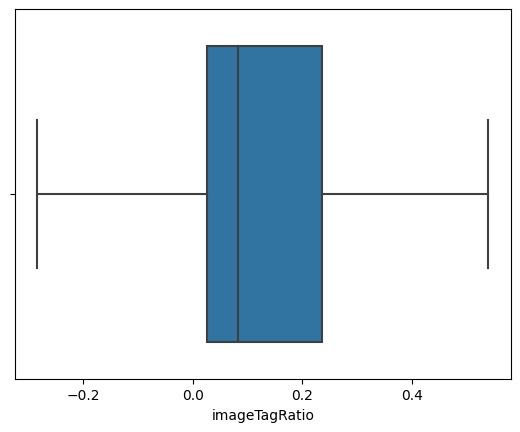

In [ ]:
# Assuming you have a DataFrame sp_web and a column "imageTagRatio" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("imageTagRatio", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("imageTagRatio").toPandas()["imageTagRatio"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("imageTagRatio", outlier_udf("imageTagRatio"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("imageTagRatio").toPandas()["imageTagRatio"])
plt.show()

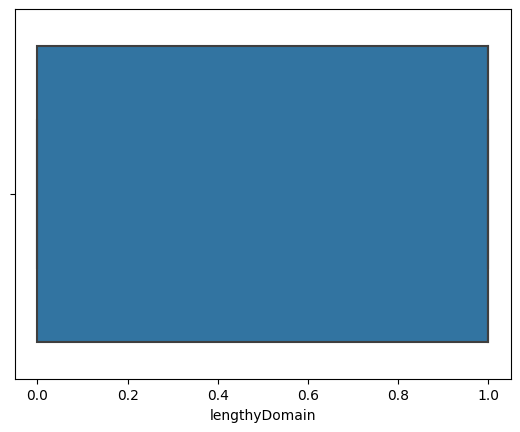

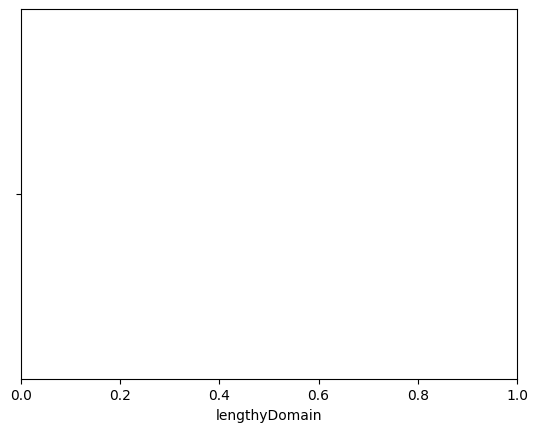

In [ ]:
# Assuming you have a DataFrame sp_web and a column "lengthyDomain" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("lengthyDomain", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("lengthyDomain").toPandas()["lengthyDomain"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("lengthyDomain", outlier_udf("lengthyDomain"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("lengthyDomain").toPandas()["lengthyDomain"])
plt.show()

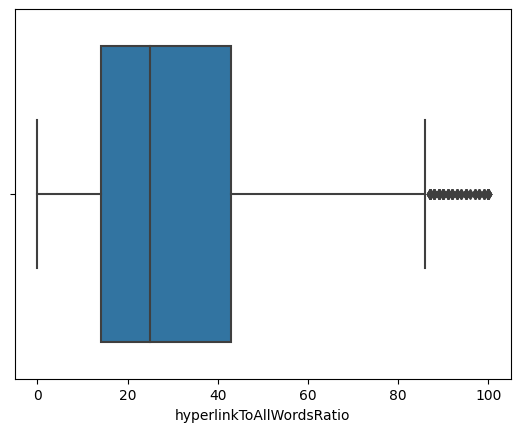

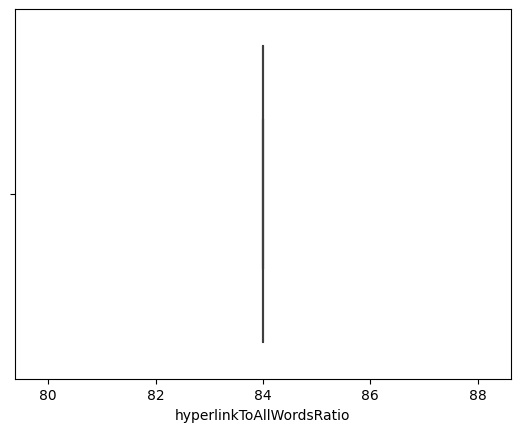

In [ ]:
# Assuming you have a DataFrame sp_web and a column "hyperlinkToAllWordsRatio" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("hyperlinkToAllWordsRatio", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("hyperlinkToAllWordsRatio").toPandas()["hyperlinkToAllWordsRatio"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("hyperlinkToAllWordsRatio", outlier_udf("hyperlinkToAllWordsRatio"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("hyperlinkToAllWordsRatio").toPandas()["hyperlinkToAllWordsRatio"])
plt.show()

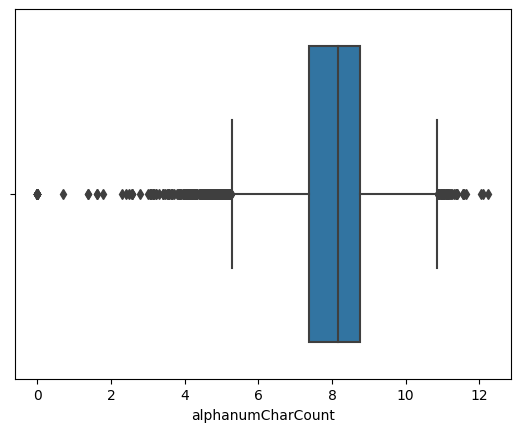

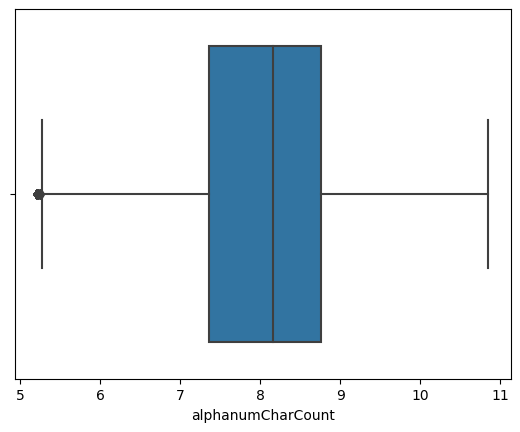

In [ ]:
# Assuming you have a DataFrame sp_web and a column "alphanumCharCount" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("alphanumCharCount", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("alphanumCharCount").toPandas()["alphanumCharCount"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("alphanumCharCount", outlier_udf("alphanumCharCount"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("alphanumCharCount").toPandas()["alphanumCharCount"])
plt.show()

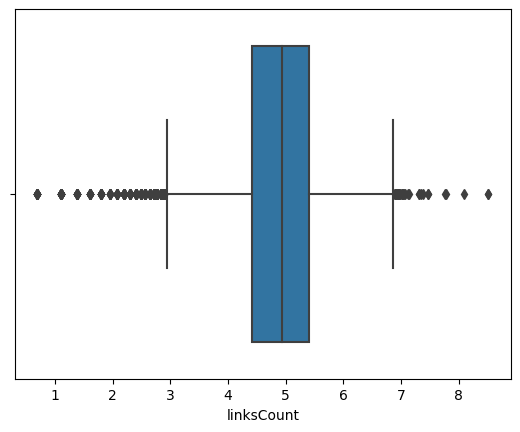

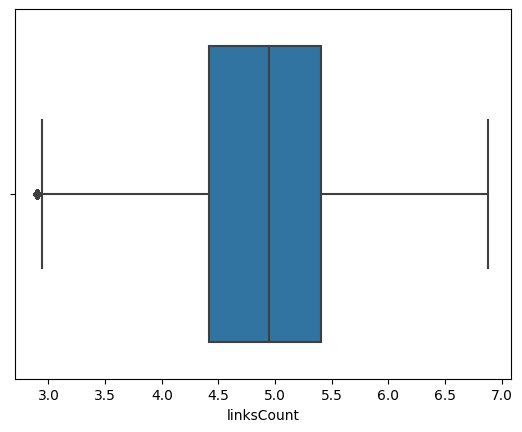

In [ ]:
# Assuming you have a DataFrame sp_web and a column "linksCount" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("linksCount", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("linksCount").toPandas()["linksCount"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("linksCount", outlier_udf("linksCount"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("linksCount").toPandas()["linksCount"])
plt.show()

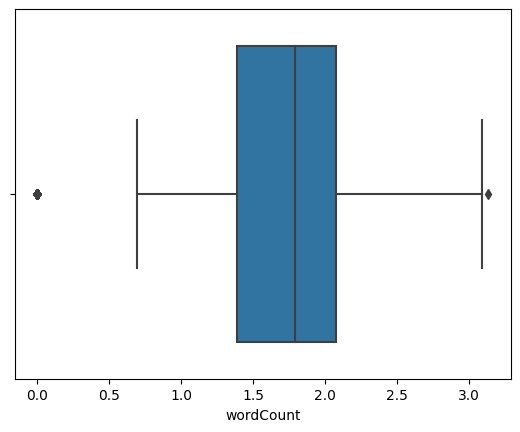

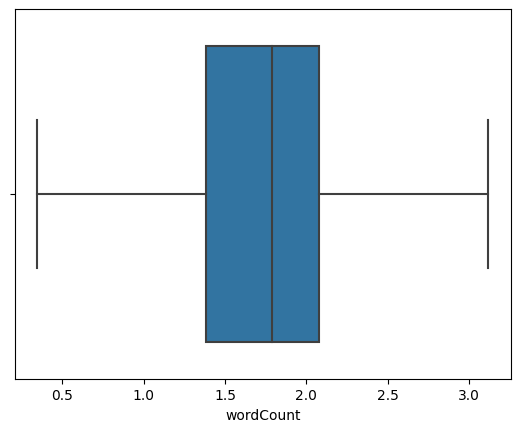

In [ ]:
# Assuming you have a DataFrame sp_web and a column "wordCount" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("wordCount", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("wordCount").toPandas()["wordCount"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("wordCount", outlier_udf("wordCount"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("wordCount").toPandas()["wordCount"])
plt.show()

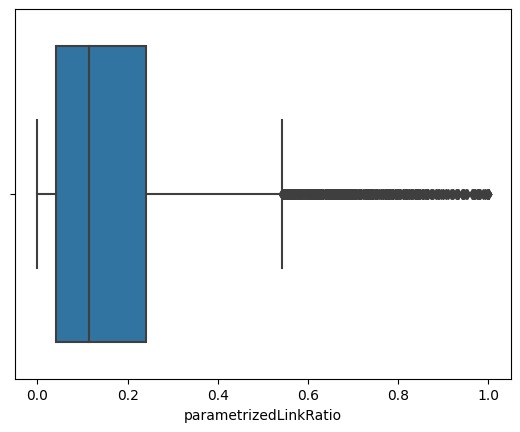

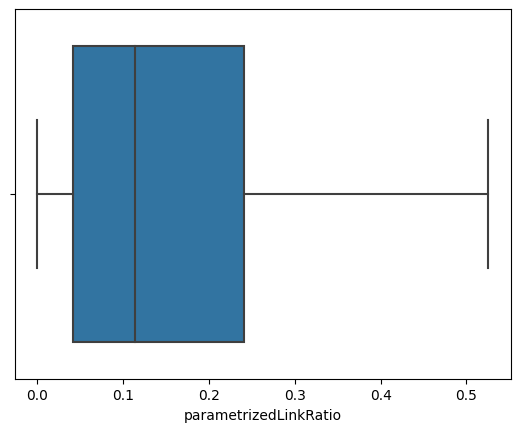

In [ ]:
# Assuming you have a DataFrame sp_web and a column "parametrizedLinkRatio" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("parametrizedLinkRatio", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("parametrizedLinkRatio").toPandas()["parametrizedLinkRatio"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("parametrizedLinkRatio", outlier_udf("parametrizedLinkRatio"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("parametrizedLinkRatio").toPandas()["parametrizedLinkRatio"])
plt.show()

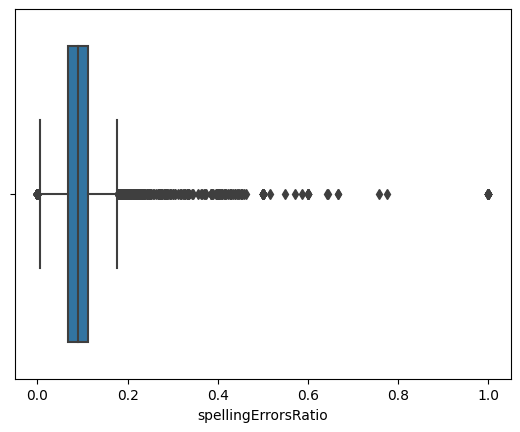

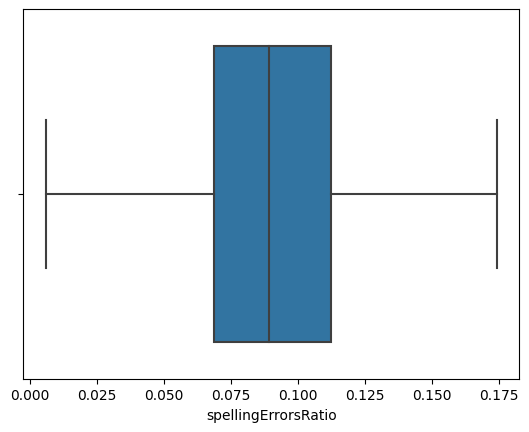

In [ ]:
# Assuming you have a DataFrame sp_web and a column "spellingErrorsRatio" for which you want to remove outliers
lower_quartile, upper_quartile = sp_web.approxQuantile("spellingErrorsRatio", [0.25, 0.75], 0.01)

# Plot boxplot before outlier removal
sns.boxplot(x=sp_web.select("spellingErrorsRatio").toPandas()["spellingErrorsRatio"])
plt.show()

# Create a UDF based on the removeOutlier method
outlier_udf = create_outlier_udf(lower_quartile, upper_quartile)
sp_web = sp_web.withColumn("spellingErrorsRatio", outlier_udf("spellingErrorsRatio"))

# Plot boxplot after outlier removal
sns.boxplot(x=sp_web.select("spellingErrorsRatio").toPandas()["spellingErrorsRatio"])
plt.show()

In [ ]:
from pyspark.sql.functions import desc

value_counts = sp_web.groupBy("alchemy_category").count().orderBy(desc("count"))
value_counts.show()

+------------------+-----+
|  alchemy_category|count|
+------------------+-----+
|           Nothing| 2342|
|        recreation| 1229|
|arts_entertainment|  941|
|          business|  880|
|            health|  506|
|            sports|  380|
|  culture_politics|  343|
| computer_internet|  296|
|science_technology|  289|
|            gaming|   76|
|          religion|   72|
|         law_crime|   31|
|           unknown|    6|
|           weather|    4|
+------------------+-----+



In [ ]:
import pandas as pd
from pyspark.sql import SparkSession

# Convert the PySpark DataFrame to pandas DataFrame
main_df = sp_web.toPandas()

# Perform one-hot encoding using pandas
column_names_to_one_hot = ["alchemy_category"]
main_df = pd.get_dummies(main_df, columns=column_names_to_one_hot)

# Convert the pandas DataFrame back to PySpark DataFrame
spark = SparkSession.builder.getOrCreate()
sp_web2 = spark.createDataFrame(main_df)


In [ ]:
sp_web2

url,webpageDescription,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id,alchemy_category_Nothing,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather
http://www.polyvo...,"{""title"":""Join Po...",1.8282044615195077,1.070441411815699,2.8508552814091734,0.007905179570105402,0.0,0.0,0.5803887359324178,0.027777778,0.203161066,0.539600802,0,NaN,NaN,0,6.52649485957079,4.844187086458591,0.6931471805599453,0.525456445,0.142857143,1,3711,1,0,0,0,0,0,0,0,0,0,0,0,0,0
http://www.youtub...,"{""body"":""Speed Ai...",1.8282044615195077,0.814291564106953,3.129976952166903,0.0,0.0,0.0,0.5803887359324178,0.015086207,0.16818907,0.539600802,0,NaN,NaN,0,8.009363076630045,4.3694478524670215,0.6931471805599453,0.525456445,0.005985266000000017,1,7222,1,0,0,0,0,0,0,0,0,0,0,0,0,0
http://www.musing...,"{""title"":""Chicken...",1.472092709027923,1.1065804583172865,5.105662382941083,0.2500165698713667,0.20982568896628795,0.18426519171126352,0.36700753003988484,0.033935018,0.192651673,0.126582278,1,NaN,NaN,0,9.306468399070404,5.552959584921617,1.791759469228055,0.46692607,0.0625,1,3964,0,0,0,0,0,0,0,0,0,0,1,0,0,0
http://www.thelit...,"{""title"":""Ikan Bi...",1.6080769112623954,0.9802994515667224,4.135384951370745,0.18173863609535845,0.09340117517757276,0.06431996538100165,0.3870628517946828,0.03652968,0.198000059,0.13559322,1,NaN,NaN,0,8.43076346341785,5.659482215759621,1.791759469228055,0.244755245,0.085867621,1,3697,0,0,0,0,0,0,0,0,1,0,0,0,0,0
http://recipes.wu...,"{""url"":""recipes w...",1.7074636093575437,0.45781950897976,2.8189476343703377,0.0,0.0,0.0,0.2566662430715346,0.015151515,0.241563622,0.054216867,0,NaN,NaN,0,7.465082736399547,4.02535169073515,0.6931471805599453,0.072727273,0.115044248,1,4321,0,0,0,1,0,0,0,0,0,0,0,0,0,0
http://www.sleepd...,"{""title"":""Discove...",2.47219462302148,1.5471191481057955,6.350190725720006,0.49247648487557194,0.17556477439887144,0.09622803208537947,0.32395521019277806,0.02244898,0.254479838,0.003398471,1,NaN,NaN,0,8.709795057617749,4.605170185988092,2.833213344056216,0.01010101,0.105439331,1,6940,0,0,0,0,0,0,1,0,0,0,0,0,0,0
http://www.inside...,"{""title"":""Insider...",2.4444691920712582,0.9902029901914591,4.3483595455110065,0.1377172508086627,0.02649161585220508,0.006688987757463276,0.4201132575386385,0.026190476,0.264696599,0.045454545,0,NaN,NaN,0,6.8690144506657065,5.0106352940962555,1.6094379124341003,0.006711409,0.086956522,1,5416,0,0,0,0,0,0,1,0,0,0,0,0,0,0
http://yawoot.com...,"{""title"":""Well th...",1.7334800888855628,0.7748252115938203,5.1290509137475215,0.0,0.0,0.0,0.23744858229494328,0.040247678,0.181395581,0.011560694,0,NaN,NaN,0,7.531552381407289,4.1588830833596715,0.6931471805599453,0.031746032,0.123209169,0,7349,0,0,0,0,0,0,0,0,1,0,0,0,0,0
http://www.bbc.co...,"{""url"":""bbc co ne...",1.7115938287337313,1.4966424183633829,4.278933105055906,0.1776811768653594,0.13005312834575877,0.12188981793690572,0.47257469185483447,0.111581921,0.234397297,0.539600802,1,NaN,NaN,0,6.885509670034818,4.6913478822291435,1.0986122886681096,0.064814815,0.085106383,0,6727,0,0,0,1,0,0,0,0,0,0,0,0,0,0
http://fxcuisine....,"{""title"":""Sicilia...",1.3328626531612828,0.6632942176223854,3.0576512595530314,0.03846628056364512,0.0,0.0,0.3970371813628889,0.088785047,0.303561825,0.034482759,1,NaN,NaN,0,7.873217054862741,3.9512437185814275,1.791759469228055,0.525456445,0.094642857,1,5155,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
import json
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# UDF to extract body from the webpageDescription column
def extract_body(description):
    try:
        data = json.loads(description)
        if "body" in data.keys() and data["body"] != ' ':
            return data["body"]
        else:
            return "Unknown"
    except:
        return "Unknown"

body_udf = udf(extract_body, StringType())
sp_web2 = sp_web2.withColumn("body", body_udf(sp_web2["webpageDescription"]))
sv1=90.8902
# UDF to extract title from the webpageDescription column
def extract_title(description):
    try:
        data = json.loads(description)
        if "title" in data.keys() and data["title"] != ' ':
            return data["title"]
        else:
            return "Unknown"
    except:
        return "Unknown"

title_udf = udf(extract_title, StringType())
sp_web2 = sp_web2.withColumn("title", title_udf(sp_web2["webpageDescription"]))

# Drop the original webpageDescription column
sp_web2 = sp_web2.drop("webpageDescription")


In [ ]:
sp_web2

url,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id,alchemy_category_Nothing,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather,body,title
http://www.polyvo...,1.8282044615195077,1.070441411815699,2.8508552814091734,0.007905179570105402,0.0,0.0,0.5803887359324178,0.027777778,0.203161066,0.539600802,0,NaN,NaN,0,6.52649485957079,4.844187086458591,0.6931471805599453,0.525456445,0.142857143,1,3711,1,0,0,0,0,0,0,0,0,0,0,0,0,0,polyvore is the ...,Join Polyvore and...
http://www.youtub...,1.8282044615195077,0.814291564106953,3.129976952166903,0.0,0.0,0.0,0.5803887359324178,0.015086207,0.16818907,0.539600802,0,NaN,NaN,0,8.009363076630045,4.3694478524670215,0.6931471805599453,0.525456445,0.005985266000000017,1,7222,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Speed Air Man--Da...,Speed Air Man--Da...
http://www.musing...,1.472092709027923,1.1065804583172865,5.105662382941083,0.2500165698713667,0.20982568896628795,0.18426519171126352,0.36700753003988484,0.033935018,0.192651673,0.126582278,1,NaN,NaN,0,9.306468399070404,5.552959584921617,1.791759469228055,0.46692607,0.0625,1,3964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Chicken Gruyere o...,Chicken Gruyere R...
http://www.thelit...,1.6080769112623954,0.9802994515667224,4.135384951370745,0.18173863609535845,0.09340117517757276,0.06431996538100165,0.3870628517946828,0.03652968,0.198000059,0.13559322,1,NaN,NaN,0,8.43076346341785,5.659482215759621,1.791759469228055,0.244755245,0.085867621,1,3697,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Oh me oh my This ...,Ikan Bilis With T...
http://recipes.wu...,1.7074636093575437,0.45781950897976,2.8189476343703377,0.0,0.0,0.0,0.2566662430715346,0.015151515,0.241563622,0.054216867,0,NaN,NaN,0,7.465082736399547,4.02535169073515,0.6931471805599453,0.072727273,0.115044248,1,4321,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Barbecued Chicken...,Malaysian recipes
http://www.sleepd...,2.47219462302148,1.5471191481057955,6.350190725720006,0.49247648487557194,0.17556477439887144,0.09622803208537947,0.32395521019277806,0.02244898,0.254479838,0.003398471,1,NaN,NaN,0,8.709795057617749,4.605170185988092,2.833213344056216,0.01010101,0.105439331,1,6940,0,0,0,0,0,0,1,0,0,0,0,0,0,0,You have to pay h...,Discover The Thre...
http://www.inside...,2.4444691920712582,0.9902029901914591,4.3483595455110065,0.1377172508086627,0.02649161585220508,0.006688987757463276,0.4201132575386385,0.026190476,0.264696599,0.045454545,0,NaN,NaN,0,6.8690144506657065,5.0106352940962555,1.6094379124341003,0.006711409,0.086956522,1,5416,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Copyright 2011 In...,InsidersHealth co...
http://yawoot.com...,1.7334800888855628,0.7748252115938203,5.1290509137475215,0.0,0.0,0.0,0.23744858229494328,0.040247678,0.181395581,0.011560694,0,NaN,NaN,0,7.531552381407289,4.1588830833596715,0.6931471805599453,0.031746032,0.123209169,0,7349,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Well the world is...,Well the world is...
http://www.bbc.co...,1.7115938287337313,1.4966424183633829,4.278933105055906,0.1776811768653594,0.13005312834575877,0.12188981793690572,0.47257469185483447,0.111581921,0.234397297,0.539600802,1,NaN,NaN,0,6.885509670034818,4.6913478822291435,1.0986122886681096,0.064814815,0.085106383,0,6727,0,0,0,1,0,0,0,0,0,0,0,0,0,0,This page is best...,BBC News Home gad...
http://fxcuisine....,1.3328626531612828,0.6632942176223854,3.0576512595530314,0.03846628056364512,0.0,0.0,0.3970371813628889,0.088785047,0.303561825,0.034482759,1,NaN,NaN,0,7.8732170

In [ ]:
from pyspark.sql.functions import regexp_replace, trim

# List of characters to replace with space
charlist = ['/','?','=','-','_','&','(',')','@','$','%','#',':',';',"<",">","."]

# Replace 'http://', 'https://', 'www.', '.com', and '.org'
sp_web2 = sp_web2.withColumn("url", regexp_replace(sp_web2["url"], 'http://', ''))
sp_web2 = sp_web2.withColumn("url", regexp_replace(sp_web2["url"], 'https://', ''))
sp_web2 = sp_web2.withColumn("url", regexp_replace(sp_web2["url"], 'www.', ''))
sp_web2 = sp_web2.withColumn("url", regexp_replace(sp_web2["url"], '.com', ''))
sp_web2 = sp_web2.withColumn("url", regexp_replace(sp_web2["url"], '.org', ''))

# Replace characters in charlist with space
for char in charlist:
    sp_web2 = sp_web2.withColumn("url", regexp_replace(sp_web2["url"], f'\\{char}', ' '))


# Remove extra spaces
sp_web2 = sp_web2.withColumn("url", trim(sp_web2["url"]))
sp_web2

url,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id,alchemy_category_Nothing,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather,body,title
polyvore cgi home...,1.8282044615195077,1.070441411815699,2.8508552814091734,0.007905179570105402,0.0,0.0,0.5803887359324178,0.027777778,0.203161066,0.539600802,0,NaN,NaN,0,6.52649485957079,4.844187086458591,0.6931471805599453,0.525456445,0.142857143,1,3711,1,0,0,0,0,0,0,0,0,0,0,0,0,0,polyvore is the ...,Join Polyvore and...
youtube watch v i...,1.8282044615195077,0.814291564106953,3.129976952166903,0.0,0.0,0.0,0.5803887359324178,0.015086207,0.16818907,0.539600802,0,NaN,NaN,0,8.009363076630045,4.3694478524670215,0.6931471805599453,0.525456445,0.005985266000000017,1,7222,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Speed Air Man--Da...,Speed Air Man--Da...
musingsofahousewi...,1.472092709027923,1.1065804583172865,5.105662382941083,0.2500165698713667,0.20982568896628795,0.18426519171126352,0.36700753003988484,0.033935018,0.192651673,0.126582278,1,NaN,NaN,0,9.306468399070404,5.552959584921617,1.791759469228055,0.46692607,0.0625,1,3964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Chicken Gruyere o...,Chicken Gruyere R...
thelittleteochew ...,1.6080769112623954,0.9802994515667224,4.135384951370745,0.18173863609535845,0.09340117517757276,0.06431996538100165,0.3870628517946828,0.03652968,0.198000059,0.13559322,1,NaN,NaN,0,8.43076346341785,5.659482215759621,1.791759469228055,0.244755245,0.085867621,1,3697,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Oh me oh my This ...,Ikan Bilis With T...
recipes wuzzle in...,1.7074636093575437,0.45781950897976,2.8189476343703377,0.0,0.0,0.0,0.2566662430715346,0.015151515,0.241563622,0.054216867,0,NaN,NaN,0,7.465082736399547,4.02535169073515,0.6931471805599453,0.072727273,0.115044248,1,4321,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Barbecued Chicken...,Malaysian recipes
sleepdisordersgui...,2.47219462302148,1.5471191481057955,6.350190725720006,0.49247648487557194,0.17556477439887144,0.09622803208537947,0.32395521019277806,0.02244898,0.254479838,0.003398471,1,NaN,NaN,0,8.709795057617749,4.605170185988092,2.833213344056216,0.01010101,0.105439331,1,6940,0,0,0,0,0,0,1,0,0,0,0,0,0,0,You have to pay h...,Discover The Thre...
insidershealth na...,2.4444691920712582,0.9902029901914591,4.3483595455110065,0.1377172508086627,0.02649161585220508,0.006688987757463276,0.4201132575386385,0.026190476,0.264696599,0.045454545,0,NaN,NaN,0,6.8690144506657065,5.0106352940962555,1.6094379124341003,0.006711409,0.086956522,1,5416,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Copyright 2011 In...,InsidersHealth co...
yawoot post 2122,1.7334800888855628,0.7748252115938203,5.1290509137475215,0.0,0.0,0.0,0.23744858229494328,0.040247678,0.181395581,0.011560694,0,NaN,NaN,0,7.531552381407289,4.1588830833596715,0.6931471805599453,0.031746032,0.123209169,0,7349,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Well the world is...,Well the world is...
bbc co uk news te...,1.7115938287337313,1.4966424183633829,4.278933105055906,0.1776811768653594,0.13005312834575877,0.12188981793690572,0.47257469185483447,0.111581921,0.234397297,0.539600802,1,NaN,NaN,0,6.885509670034818,4.6913478822291435,1.0986122886681096,0.064814815,0.085106383,0,6727,0,0,0,1,0,0,0,0,0,0,0,0,0,0,This page is best...,BBC News Home gad...
fxcuisine default...,1.3328626531612828,0.6632942176223854,3.0576512595530314,0.03846628056364512,0.0,0.0,0.3970371813628889,0.088785047,0.303561825,0.034482759,1,NaN,NaN,0,7.87321705486

In [ ]:
from pyspark.sql import functions as F

null_counts = sp_web2.agg(*[F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in sp_web2.columns])
null_counts.show(vertical=True)

-RECORD 0-----------------------------------
 url                                 | 0    
 alchemy_category_score              | 0    
 avgLinkWordLength                   | 0    
 AvglinkWithOneCommonWord            | 0    
 AvglinkWithTwoCommonWord            | 0    
 AvglinkWithThreeCommonWord          | 0    
 AvglinkWithFourCommonWord           | 0    
 redundancyMeasure                   | 0    
 frameTagRatio                       | 0    
 tagRatio                            | 0    
 imageTagRatio                       | 0    
 isNews                              | 0    
 lengthyDomain                       | 0    
 hyperlinkToAllWordsRatio            | 0    
 isFrontPageNews                     | 0    
 alphanumCharCount                   | 0    
 linksCount                          | 0    
 wordCount                           | 0    
 parametrizedLinkRatio               | 0    
 spellingErrorsRatio                 | 0    
 label                               | 1479 
 id       

In [ ]:
from pyspark.sql.functions import when, col

# Replace null values in the 'title' column with "Unknown"
sp_web2 = sp_web2.withColumn("title", when(col("title").isNull(), "NoTitle").otherwise(col("title")))

# Replace null values in the 'body' column with "Unknown"
sp_web2 = sp_web2.withColumn("body", when(col("body").isNull(), "NoBody").otherwise(col("body")))


In [ ]:
from pyspark.sql import functions as F

null_counts = sp_web2.agg(*[F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in sp_web2.columns])
null_counts.show(vertical=True)

-RECORD 0-----------------------------------
 url                                 | 0    
 alchemy_category_score              | 0    
 avgLinkWordLength                   | 0    
 AvglinkWithOneCommonWord            | 0    
 AvglinkWithTwoCommonWord            | 0    
 AvglinkWithThreeCommonWord          | 0    
 AvglinkWithFourCommonWord           | 0    
 redundancyMeasure                   | 0    
 frameTagRatio                       | 0    
 tagRatio                            | 0    
 imageTagRatio                       | 0    
 isNews                              | 0    
 lengthyDomain                       | 0    
 hyperlinkToAllWordsRatio            | 0    
 isFrontPageNews                     | 0    
 alphanumCharCount                   | 0    
 linksCount                          | 0    
 wordCount                           | 0    
 parametrizedLinkRatio               | 0    
 spellingErrorsRatio                 | 0    
 label                               | 1479 
 id       

In [ ]:
from pyspark.sql.functions import udf, col, regexp_replace, trim
from pyspark.sql.types import StringType
import string

# Define a UDF to remove punctuation
def remove_punct(text):
    return ''.join([c for c in text if c not in string.punctuation])

remove_punct_udf = udf(remove_punct, StringType())

# Apply the UDF to the 'body', 'title', and 'url' columns
sp_web2 = sp_web2.withColumn("body", trim(col("body")))
sp_web2 = sp_web2.withColumn("body", remove_punct_udf(col("body")))

sp_web2 = sp_web2.withColumn("title", trim(col("title")))
sp_web2 = sp_web2.withColumn("title", remove_punct_udf(col("title")))

sp_web2 = sp_web2.withColumn("url", trim(col("url")))
sp_web2 = sp_web2.withColumn("url", remove_punct_udf(col("url")))


In [ ]:
sp_web2

url,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id,alchemy_category_Nothing,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather,body,title
polyvore cgi home...,1.8282044615195077,1.070441411815699,2.8508552814091734,0.007905179570105402,0.0,0.0,0.5803887359324178,0.027777778,0.203161066,0.539600802,0,NaN,NaN,0,6.52649485957079,4.844187086458591,0.6931471805599453,0.525456445,0.142857143,1,3711,1,0,0,0,0,0,0,0,0,0,0,0,0,0,polyvore is the b...,Join Polyvore and...
youtube watch v i...,1.8282044615195077,0.814291564106953,3.129976952166903,0.0,0.0,0.0,0.5803887359324178,0.015086207,0.16818907,0.539600802,0,NaN,NaN,0,8.009363076630045,4.3694478524670215,0.6931471805599453,0.525456445,0.005985266000000017,1,7222,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Speed Air ManDavi...,Speed Air ManDavi...
musingsofahousewi...,1.472092709027923,1.1065804583172865,5.105662382941083,0.2500165698713667,0.20982568896628795,0.18426519171126352,0.36700753003988484,0.033935018,0.192651673,0.126582278,1,NaN,NaN,0,9.306468399070404,5.552959584921617,1.791759469228055,0.46692607,0.0625,1,3964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Chicken Gruyere o...,Chicken Gruyere R...
thelittleteochew ...,1.6080769112623954,0.9802994515667224,4.135384951370745,0.18173863609535845,0.09340117517757276,0.06431996538100165,0.3870628517946828,0.03652968,0.198000059,0.13559322,1,NaN,NaN,0,8.43076346341785,5.659482215759621,1.791759469228055,0.244755245,0.085867621,1,3697,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Oh me oh my This ...,Ikan Bilis With T...
recipes wuzzle in...,1.7074636093575437,0.45781950897976,2.8189476343703377,0.0,0.0,0.0,0.2566662430715346,0.015151515,0.241563622,0.054216867,0,NaN,NaN,0,7.465082736399547,4.02535169073515,0.6931471805599453,0.072727273,0.115044248,1,4321,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Barbecued Chicken...,Malaysian recipes
sleepdisordersgui...,2.47219462302148,1.5471191481057955,6.350190725720006,0.49247648487557194,0.17556477439887144,0.09622803208537947,0.32395521019277806,0.02244898,0.254479838,0.003398471,1,NaN,NaN,0,8.709795057617749,4.605170185988092,2.833213344056216,0.01010101,0.105439331,1,6940,0,0,0,0,0,0,1,0,0,0,0,0,0,0,You have to pay h...,Discover The Thre...
insidershealth na...,2.4444691920712582,0.9902029901914591,4.3483595455110065,0.1377172508086627,0.02649161585220508,0.006688987757463276,0.4201132575386385,0.026190476,0.264696599,0.045454545,0,NaN,NaN,0,6.8690144506657065,5.0106352940962555,1.6094379124341003,0.006711409,0.086956522,1,5416,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Copyright 2011 In...,InsidersHealth co...
yawoot post 2122,1.7334800888855628,0.7748252115938203,5.1290509137475215,0.0,0.0,0.0,0.23744858229494328,0.040247678,0.181395581,0.011560694,0,NaN,NaN,0,7.531552381407289,4.1588830833596715,0.6931471805599453,0.031746032,0.123209169,0,7349,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Well the world is...,Well the world is...
bbc co uk news te...,1.7115938287337313,1.4966424183633829,4.278933105055906,0.1776811768653594,0.13005312834575877,0.12188981793690572,0.47257469185483447,0.111581921,0.234397297,0.539600802,1,NaN,NaN,0,6.885509670034818,4.6913478822291435,1.0986122886681096,0.064814815,0.085106383,0,6727,0,0,0,1,0,0,0,0,0,0,0,0,0,0,This page is best...,BBC News Home gad...
fxcuisine default...,1.3328626531612828,0.6632942176223854,3.0576512595530314,0.03846628056364512,0.0,0.0,0.3970371813628889,0.088785047,0.303561825,0.034482759,1,NaN,NaN,0,7.8732170548

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
import re

# Define a UDF to tokenize the text
def tokenize(text):
    return re.split('\W+', text)

tokenize_udf = udf(tokenize, ArrayType(StringType()))

# Apply the UDF to the 'body', 'title', and 'url' columns
sp_web2 = sp_web2.withColumn("body", tokenize_udf(col("body")))
sp_web2 = sp_web2.withColumn("title", tokenize_udf(col("title")))
sp_web2 = sp_web2.withColumn("url", tokenize_udf(col("url")))
sp_web2

url,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id,alchemy_category_Nothing,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather,body,title
"[polyvore, cgi, h...",1.8282044615195077,1.070441411815699,2.8508552814091734,0.007905179570105402,0.0,0.0,0.5803887359324178,0.027777778,0.203161066,0.539600802,0,NaN,NaN,0,6.52649485957079,4.844187086458591,0.6931471805599453,0.525456445,0.142857143,1,3711,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[polyvore, is, th...","[Join, Polyvore, ..."
"[youtube, watch, ...",1.8282044615195077,0.814291564106953,3.129976952166903,0.0,0.0,0.0,0.5803887359324178,0.015086207,0.16818907,0.539600802,0,NaN,NaN,0,8.009363076630045,4.3694478524670215,0.6931471805599453,0.525456445,0.005985266000000017,1,7222,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[Speed, Air, ManD...","[Speed, Air, ManD..."
[musingsofahousew...,1.472092709027923,1.1065804583172865,5.105662382941083,0.2500165698713667,0.20982568896628795,0.18426519171126352,0.36700753003988484,0.033935018,0.192651673,0.126582278,1,NaN,NaN,0,9.306468399070404,5.552959584921617,1.791759469228055,0.46692607,0.0625,1,3964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[Chicken, Gruyere...","[Chicken, Gruyere..."
[thelittleteochew...,1.6080769112623954,0.9802994515667224,4.135384951370745,0.18173863609535845,0.09340117517757276,0.06431996538100165,0.3870628517946828,0.03652968,0.198000059,0.13559322,1,NaN,NaN,0,8.43076346341785,5.659482215759621,1.791759469228055,0.244755245,0.085867621,1,3697,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"[Oh, me, oh, my, ...","[Ikan, Bilis, Wit..."
"[recipes, wuzzle,...",1.7074636093575437,0.45781950897976,2.8189476343703377,0.0,0.0,0.0,0.2566662430715346,0.015151515,0.241563622,0.054216867,0,NaN,NaN,0,7.465082736399547,4.02535169073515,0.6931471805599453,0.072727273,0.115044248,1,4321,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Barbecued, Chick...","[Malaysian, recipes]"
[sleepdisordersgu...,2.47219462302148,1.5471191481057955,6.350190725720006,0.49247648487557194,0.17556477439887144,0.09622803208537947,0.32395521019277806,0.02244898,0.254479838,0.003398471,1,NaN,NaN,0,8.709795057617749,4.605170185988092,2.833213344056216,0.01010101,0.105439331,1,6940,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"[You, have, to, p...","[Discover, The, T..."
"[insidershealth, ...",2.4444691920712582,0.9902029901914591,4.3483595455110065,0.1377172508086627,0.02649161585220508,0.006688987757463276,0.4201132575386385,0.026190476,0.264696599,0.045454545,0,NaN,NaN,0,6.8690144506657065,5.0106352940962555,1.6094379124341003,0.006711409,0.086956522,1,5416,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"[Copyright, 2011,...","[InsidersHealth, ..."
"[yawoot, post, 2122]",1.7334800888855628,0.7748252115938203,5.1290509137475215,0.0,0.0,0.0,0.23744858229494328,0.040247678,0.181395581,0.011560694,0,NaN,NaN,0,7.531552381407289,4.1588830833596715,0.6931471805599453,0.031746032,0.123209169,0,7349,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"[Well, the, world...","[Well, the, world..."
"[bbc, co, uk, new...",1.7115938287337313,1.4966424183633829,4.278933105055906,0.1776811768653594,0.13005312834575877,0.12188981793690572,0.47257469185483447,0.111581921,0.234397297,0.539600802,1,NaN,NaN,0,6.885509670034818,4.6913478822291435,1.0986122886681096,0.064814815,0.085106383,0,6727,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[This, page, is, ...","[BBC, News, Home,..."
"[fxcuisine, defau...",1.3328626531612828,0.6632942176223854,3.0576512595530314,0.03846628056364512,0.0,0.0,0.3970371813628889,0.0

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

# Define a UDF to remove stopwords from a tokenized list
def remove_stopwords(tokenized_list):
    return [word for word in tokenized_list if word not in stopwords_list]

remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))

# Apply the UDF to the 'body', 'title', and 'url' columns
sp_web2 = sp_web2.withColumn("body", remove_stopwords_udf(col("body")))
sp_web2 = sp_web2.withColumn("title", remove_stopwords_udf(col("title")))
sp_web2 = sp_web2.withColumn("url", remove_stopwords_udf(col("url")))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
sp_web2

url,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id,alchemy_category_Nothing,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather,body,title
"[polyvore, cgi, h...",1.8282044615195077,1.070441411815699,2.8508552814091734,0.007905179570105402,0.0,0.0,0.5803887359324178,0.027777778,0.203161066,0.539600802,0,NaN,NaN,0,6.52649485957079,4.844187086458591,0.6931471805599453,0.525456445,0.142857143,1,3711,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[polyvore, best, ...","[Join, Polyvore, ..."
"[youtube, watch, ...",1.8282044615195077,0.814291564106953,3.129976952166903,0.0,0.0,0.0,0.5803887359324178,0.015086207,0.16818907,0.539600802,0,NaN,NaN,0,8.009363076630045,4.3694478524670215,0.6931471805599453,0.525456445,0.005985266000000017,1,7222,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[Speed, Air, ManD...","[Speed, Air, ManD..."
[musingsofahousew...,1.472092709027923,1.1065804583172865,5.105662382941083,0.2500165698713667,0.20982568896628795,0.18426519171126352,0.36700753003988484,0.033935018,0.192651673,0.126582278,1,NaN,NaN,0,9.306468399070404,5.552959584921617,1.791759469228055,0.46692607,0.0625,1,3964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[Chicken, Gruyere...","[Chicken, Gruyere..."
[thelittleteochew...,1.6080769112623954,0.9802994515667224,4.135384951370745,0.18173863609535845,0.09340117517757276,0.06431996538100165,0.3870628517946828,0.03652968,0.198000059,0.13559322,1,NaN,NaN,0,8.43076346341785,5.659482215759621,1.791759469228055,0.244755245,0.085867621,1,3697,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"[Oh, oh, This, re...","[Ikan, Bilis, Wit..."
"[recipes, wuzzle,...",1.7074636093575437,0.45781950897976,2.8189476343703377,0.0,0.0,0.0,0.2566662430715346,0.015151515,0.241563622,0.054216867,0,NaN,NaN,0,7.465082736399547,4.02535169073515,0.6931471805599453,0.072727273,0.115044248,1,4321,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Barbecued, Chick...","[Malaysian, recipes]"
[sleepdisordersgu...,2.47219462302148,1.5471191481057955,6.350190725720006,0.49247648487557194,0.17556477439887144,0.09622803208537947,0.32395521019277806,0.02244898,0.254479838,0.003398471,1,NaN,NaN,0,8.709795057617749,4.605170185988092,2.833213344056216,0.01010101,0.105439331,1,6940,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"[You, pay, high, ...","[Discover, The, T..."
"[insidershealth, ...",2.4444691920712582,0.9902029901914591,4.3483595455110065,0.1377172508086627,0.02649161585220508,0.006688987757463276,0.4201132575386385,0.026190476,0.264696599,0.045454545,0,NaN,NaN,0,6.8690144506657065,5.0106352940962555,1.6094379124341003,0.006711409,0.086956522,1,5416,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"[Copyright, 2011,...","[InsidersHealth, ..."
"[yawoot, post, 2122]",1.7334800888855628,0.7748252115938203,5.1290509137475215,0.0,0.0,0.0,0.23744858229494328,0.040247678,0.181395581,0.011560694,0,NaN,NaN,0,7.531552381407289,4.1588830833596715,0.6931471805599453,0.031746032,0.123209169,0,7349,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"[Well, world, mad...","[Well, world, mad..."
"[bbc, co, uk, new...",1.7115938287337313,1.4966424183633829,4.278933105055906,0.1776811768653594,0.13005312834575877,0.12188981793690572,0.47257469185483447,0.111581921,0.234397297,0.539600802,1,NaN,NaN,0,6.885509670034818,4.6913478822291435,1.0986122886681096,0.064814815,0.085106383,0,6727,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[This, page, best...","[BBC, News, Home,..."
"[fxcuisine, defau...",1.3328626531612828,0.6632942176223854,3.0576512595530314,0.03846628056364512,0.0,0.0,0.3970371813628889,0.0

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
import nltk
from nltk.stem import WordNetLemmatizer

# Initialize the WordNetLemmatizer
wnl = WordNetLemmatizer()

# Define a UDF to lemmatize a tokenized list
def lemmatizing(tokenized_text):
    return [wnl.lemmatize(word) for word in tokenized_text]

lemmatizing_udf = udf(lemmatizing, ArrayType(StringType()))

# Apply the UDF to the 'body', 'title', and 'url' columns
sp_web2 = sp_web2.withColumn("body", lemmatizing_udf(col("body")))
sp_web2 = sp_web2.withColumn("title", lemmatizing_udf(col("title")))
sp_web2 = sp_web2.withColumn("url", lemmatizing_udf(col("url")))
sp_web2

url,alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,label,id,alchemy_category_Nothing,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather,body,title
"[polyvore, cgi, h...",1.8282044615195077,1.070441411815699,2.8508552814091734,0.007905179570105402,0.0,0.0,0.5803887359324178,0.027777778,0.203161066,0.539600802,0,NaN,NaN,0,6.52649485957079,4.844187086458591,0.6931471805599453,0.525456445,0.142857143,1,3711,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[polyvore, best, ...","[Join, Polyvore, ..."
"[youtube, watch, ...",1.8282044615195077,0.814291564106953,3.129976952166903,0.0,0.0,0.0,0.5803887359324178,0.015086207,0.16818907,0.539600802,0,NaN,NaN,0,8.009363076630045,4.3694478524670215,0.6931471805599453,0.525456445,0.005985266000000017,1,7222,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[Speed, Air, ManD...","[Speed, Air, ManD..."
[musingsofahousew...,1.472092709027923,1.1065804583172865,5.105662382941083,0.2500165698713667,0.20982568896628795,0.18426519171126352,0.36700753003988484,0.033935018,0.192651673,0.126582278,1,NaN,NaN,0,9.306468399070404,5.552959584921617,1.791759469228055,0.46692607,0.0625,1,3964,0,0,0,0,0,0,0,0,0,0,1,0,0,0,"[Chicken, Gruyere...","[Chicken, Gruyere..."
[thelittleteochew...,1.6080769112623954,0.9802994515667224,4.135384951370745,0.18173863609535845,0.09340117517757276,0.06431996538100165,0.3870628517946828,0.03652968,0.198000059,0.13559322,1,NaN,NaN,0,8.43076346341785,5.659482215759621,1.791759469228055,0.244755245,0.085867621,1,3697,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"[Oh, oh, This, re...","[Ikan, Bilis, Wit..."
"[recipe, wuzzle, ...",1.7074636093575437,0.45781950897976,2.8189476343703377,0.0,0.0,0.0,0.2566662430715346,0.015151515,0.241563622,0.054216867,0,NaN,NaN,0,7.465082736399547,4.02535169073515,0.6931471805599453,0.072727273,0.115044248,1,4321,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[Barbecued, Chick...","[Malaysian, recipe]"
[sleepdisordersgu...,2.47219462302148,1.5471191481057955,6.350190725720006,0.49247648487557194,0.17556477439887144,0.09622803208537947,0.32395521019277806,0.02244898,0.254479838,0.003398471,1,NaN,NaN,0,8.709795057617749,4.605170185988092,2.833213344056216,0.01010101,0.105439331,1,6940,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"[You, pay, high, ...","[Discover, The, T..."
"[insidershealth, ...",2.4444691920712582,0.9902029901914591,4.3483595455110065,0.1377172508086627,0.02649161585220508,0.006688987757463276,0.4201132575386385,0.026190476,0.264696599,0.045454545,0,NaN,NaN,0,6.8690144506657065,5.0106352940962555,1.6094379124341003,0.006711409,0.086956522,1,5416,0,0,0,0,0,0,1,0,0,0,0,0,0,0,"[Copyright, 2011,...","[InsidersHealth, ..."
"[yawoot, post, 2122]",1.7334800888855628,0.7748252115938203,5.1290509137475215,0.0,0.0,0.0,0.23744858229494328,0.040247678,0.181395581,0.011560694,0,NaN,NaN,0,7.531552381407289,4.1588830833596715,0.6931471805599453,0.031746032,0.123209169,0,7349,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"[Well, world, mad...","[Well, world, mad..."
"[bbc, co, uk, new...",1.7115938287337313,1.4966424183633829,4.278933105055906,0.1776811768653594,0.13005312834575877,0.12188981793690572,0.47257469185483447,0.111581921,0.234397297,0.539600802,1,NaN,NaN,0,6.885509670034818,4.6913478822291435,1.0986122886681096,0.064814815,0.085106383,0,6727,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[This, page, best...","[BBC, News, Home,..."
"[fxcuisine, defau...",1.3328626531612828,0.6632942176223854,3.0576512595530314,0.03846628056364512,0.0,0.0,0.3970371813628889,0.08

In [ ]:
from pyspark.sql.functions import udf, col, concat_ws
from pyspark.sql.types import StringType

# Define a UDF to join a list of strings into a single string
def join_list(tokenized_text):
    return ' '.join(tokenized_text)

join_list_udf = udf(join_list, StringType())

# Apply the UDF to the 'body', 'title', and 'url' columns
sp_web2 = sp_web2.withColumn("body", join_list_udf(col("body")))
sp_web2 = sp_web2.withColumn("title", join_list_udf(col("title")))
sp_web2 = sp_web2.withColumn("url", join_list_udf(col("url")))

# Alternatively, you can use the built-in `concat_ws` function
# sp_web2 = sp_web2.withColumn("body", concat_ws(" ", col("body")))
# sp_web2 = sp_web2.withColumn("title", concat_ws(" ", col("title")))
# sp_web2 = sp_web2.withColumn("url", concat_ws(" ", col("url")))

# Describe the DataFrame
sp_web2.describe().show()


+-------+--------------------+----------------------+------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------+------------------------+-------------------+------------------+------------------+------------------+---------------------+--------------------+-------------------+-----------------+------------------------+-----------------------------------+-------------------------+----------------------------------+---------------------------------+-----------------------+-----------------------+--------------------------+---------------------------+-------------------------+-----------------------------------+-----------------------+------------------------+------------------------+----------------------------------+-------------------------------------+
|summary|                 url|alchemy_category_score| avgLi

In [ ]:
from pyspark.sql.functions import col, concat_ws

# Create new columns 'label_out', 'id_out', and 'total_description'
sp_web2 = sp_web2.withColumn("label_out", col("label"))
sp_web2 = sp_web2.withColumn("id_out", col("id"))
sp_web2 = sp_web2.withColumn("total_description", concat_ws(" ", col("title"), col("body"), col("url")))

# Drop the specified columns
columns_to_be_deleted = ["title", "body", "url", "label", "id"]
sp_web2 = sp_web2.drop(*columns_to_be_deleted)
sp_web2

alchemy_category_score,avgLinkWordLength,AvglinkWithOneCommonWord,AvglinkWithTwoCommonWord,AvglinkWithThreeCommonWord,AvglinkWithFourCommonWord,redundancyMeasure,frameTagRatio,tagRatio,imageTagRatio,isNews,lengthyDomain,hyperlinkToAllWordsRatio,isFrontPageNews,alphanumCharCount,linksCount,wordCount,parametrizedLinkRatio,spellingErrorsRatio,alchemy_category_Nothing,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather,label_out,id_out,total_description
1.8282044615195077,1.070441411815699,2.8508552814091734,0.007905179570105402,0.0,0.0,0.5803887359324178,0.027777778,0.203161066,0.539600802,0,NaN,NaN,0,6.52649485957079,4.844187086458591,0.6931471805599453,0.525456445,0.142857143,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3711,Join Polyvore fol...
1.8282044615195077,0.814291564106953,3.129976952166903,0.0,0.0,0.0,0.5803887359324178,0.015086207,0.16818907,0.539600802,0,NaN,NaN,0,8.009363076630045,4.3694478524670215,0.6931471805599453,0.525456445,0.005985266000000017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7222,Speed Air ManDavi...
1.472092709027923,1.1065804583172865,5.105662382941083,0.2500165698713667,0.20982568896628795,0.18426519171126352,0.36700753003988484,0.033935018,0.192651673,0.126582278,1,NaN,NaN,0,9.306468399070404,5.552959584921617,1.791759469228055,0.46692607,0.0625,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3964,Chicken Gruyere R...
1.6080769112623954,0.9802994515667224,4.135384951370745,0.18173863609535845,0.09340117517757276,0.06431996538100165,0.3870628517946828,0.03652968,0.198000059,0.13559322,1,NaN,NaN,0,8.43076346341785,5.659482215759621,1.791759469228055,0.244755245,0.085867621,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3697,Ikan Bilis With T...
1.7074636093575437,0.45781950897976,2.8189476343703377,0.0,0.0,0.0,0.2566662430715346,0.015151515,0.241563622,0.054216867,0,NaN,NaN,0,7.465082736399547,4.02535169073515,0.6931471805599453,0.072727273,0.115044248,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4321,Malaysian recipe ...
2.47219462302148,1.5471191481057955,6.350190725720006,0.49247648487557194,0.17556477439887144,0.09622803208537947,0.32395521019277806,0.02244898,0.254479838,0.003398471,1,NaN,NaN,0,8.709795057617749,4.605170185988092,2.833213344056216,0.01010101,0.105439331,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,6940,Discover The Thre...
2.4444691920712582,0.9902029901914591,4.3483595455110065,0.1377172508086627,0.02649161585220508,0.006688987757463276,0.4201132575386385,0.026190476,0.264696599,0.045454545,0,NaN,NaN,0,6.8690144506657065,5.0106352940962555,1.6094379124341003,0.006711409,0.086956522,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,5416,InsidersHealth co...
1.7334800888855628,0.7748252115938203,5.1290509137475215,0.0,0.0,0.0,0.23744858229494328,0.040247678,0.181395581,0.011560694,0,NaN,NaN,0,7.531552381407289,4.1588830833596715,0.6931471805599453,0.031746032,0.123209169,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7349,Well world made p...
1.7115938287337313,1.4966424183633829,4.278933105055906,0.1776811768653594,0.13005312834575877,0.12188981793690572,0.47257469185483447,0.111581921,0.234397297,0.539600802,1,NaN,NaN,0,6.885509670034818,4.6913478822291435,1.0986122886681096,0.064814815,0.085106383,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6727,BBC News Home gad...
1.3328626531612828,0.6632942176223854,3.0576512595530314,0.03846628056364512,0.0,0.0,0.3970371813628889,0.088785047,0.303561825,0.034482759,1,NaN,NaN,0,7.873217054862741,3.9512437185814275,1.791759469228055,0.525456445,0.094642857,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5155,Sicilian Tangerin...


In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# import pandas as pd

# # 1. Convert the PySpark DataFrame to a Pandas DataFrame
# main_df = sp_web2.toPandas()

# # 2. Apply the TF-IDF transformation
# tfidf_vect = TfidfVectorizer(stop_words='english', max_features=3000)
# X_tfidf = tfidf_vect.fit_transform(main_df['total_description'])
# names_list = tfidf_vect.get_feature_names_out()
# tfidf = X_tfidf.todense()

# # Convert the TF-IDF matrix to a Pandas DataFrame
# df = pd.DataFrame(tfidf, columns=names_list)

# main_df_list = main_df.to_numpy()
# column_names = main_df.columns
# main_df = pd.DataFrame(main_df_list, columns = column_names)
# main_df



In [ ]:
# main_df = pd.concat([main_df,df], axis = 1)
# columns_to_be_deleted = ["total_description"]
# main_df.drop(axis="columns", labels=columns_to_be_deleted, inplace=True)
# main_df["label_out"].isna().sum()


In [ ]:
# sp_web2 = spark.createDataFrame(main_df)

# # Display the resulting PySpark DataFrame
# sp_web2.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Step 1: Convert the PySpark DataFrame to a Pandas DataFrame
main_df = sp_web2.toPandas()

# Step 2: Apply the TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(stop_words='english', max_features=3000)
X_tfidf = tfidf_vect.fit_transform(main_df['total_description'])
names_list = tfidf_vect.get_feature_names_out()  # Use get_feature_names_out() for newer versions of scikit-learn
tfidf_df = pd.DataFrame(X_tfidf.todense(), columns=names_list)

# Step 3: Concatenate the TF-IDF features to the original DataFrame
main_df = pd.concat([main_df, tfidf_df], axis=1)

# Step 4: Drop the total_description column
main_df.drop(columns=["total_description"], inplace=True)


In [ ]:
train_df = main_df.loc[main_df["label_out"].isna() == False,:]
test_df = main_df.loc[main_df["label_out"].isna(),:].drop(columns="label_out")

train_df = train_df.drop(columns="id_out")

In [ ]:
main_x = train_df.drop(columns="label_out").to_numpy().astype("float")
main_y = train_df["label_out"].to_numpy().astype("float")

train_x, test_x, train_y, test_y = train_test_split(main_x, main_y, train_size=0.6, stratify=main_y)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)

test_x_scaled = scaler.transform(test_x)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
nan_values = np.isnan(train_x_scaled)
nan_values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to our data
train_x_imputed = imputer.fit_transform(train_x_scaled)
test_x_imputed = imputer.transform(test_x_scaled)

# Then apply PCA
pca = PCA(n_components=300)
train_x_pca = pca.fit_transform(train_x_imputed)
test_x_pca = pca.transform(test_x_imputed)

In [ ]:
model_names=[]
model_accuracies=[]

In [ ]:
sv = SVC(kernel = 'rbf',class_weight = "balanced",C = 0.6, probability = True)
sv.fit(train_x_pca, train_y)

SVC(C=0.6, class_weight='balanced', probability=True)

In [ ]:
test_yhat = sv.predict_proba(test_x_pca)[:,-1]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test_y_pred = sv.predict(test_x_pca)

print("Support Vector Machine")

sc1=metrics.roc_auc_score(test_y, test_yhat)
print(f"AUC score: {sc1:.4f}")

# Compute accuracy
svl = accuracy_score(test_y, test_y_pred)*100
print(f"Accuracy: {sv1:.4f}")

# Precision
precision = precision_score(test_y, test_y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(test_y, test_y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(test_y, test_y_pred)
print(f"F1 Score: {f1:.4f}")

model_names.append('Support Vector Machine')
model_accuracies.append(sv1)

Support Vector Machine
AUC score: 0.8608
Accuracy: 90.8902
Precision: 0.8432
Recall: 0.7296
F1 Score: 0.7823


In [ ]:
nn = MLPClassifier(hidden_layer_sizes=(40,50,60,70,60,50,40), activation='logistic', solver='adam', max_iter=5000, alpha=1e-5)
nn.fit(train_x_pca, train_y)
test_yhat_clf = nn.predict_proba(test_x_pca)[:,-1]

In [ ]:
from sklearn.metrics import accuracy_score
test_y_pred = nn.predict(test_x_pca)

print("Neural Net- MLP classifier")


auc_score=metrics.roc_auc_score(test_y, test_yhat_clf)
print(f"AUC score: {auc_score:.4f}")

# Compute accuracy
accuracy = accuracy_score(test_y, test_y_pred)*100
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(test_y, test_y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(test_y, test_y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(test_y, test_y_pred)
print(f"F1 Score: {f1:.4f}")

model_names.append('Neural network')
model_accuracies.append(accuracy)

Neural Net- MLP classifier
AUC score: 0.8551
Accuracy: 79.1719
Precision: 0.8350
Recall: 0.7443
F1 Score: 0.7870


In [ ]:
dt = DecisionTreeClassifier(class_weight = "balanced" ,random_state=0)
dt.fit(train_x_pca, train_y)
test_yhat_clf = dt.predict_proba(test_x_pca)[:,-1]

In [ ]:
from sklearn.metrics import accuracy_score
test_y_pred = dt.predict(test_x_pca)

print("Decision Tree classifier")


auc_score=metrics.roc_auc_score(test_y, test_yhat_clf)
print(f"AUC score: {auc_score:.4f}")

# Compute accuracy
accuracy = accuracy_score(test_y, test_y_pred)*100
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(test_y, test_y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(test_y, test_y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(test_y, test_y_pred)
print(f"F1 Score: {f1:.4f}")

model_names.append('Decision Tree')
model_accuracies.append(accuracy)

Decision Tree classifier
AUC score: 0.7314
Accuracy: 73.2573
Precision: 0.7307
Recall: 0.7647
F1 Score: 0.7473


In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(boosting_type='gbdt',
                          num_leaves=31,
                          max_depth=-1,
                          learning_rate=0.1,
                          n_estimators=100,
                          objective='binary',
                          random_state=42)
lgbm.fit(train_x_pca, train_y)
test_yhat_ada = lgbm.predict_proba(test_x_pca)[:,-1]


[LightGBM] [Info] Number of positive: 1836, number of negative: 1713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 3549, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517329 -> initscore=0.069343
[LightGBM] [Info] Start training from score 0.069343


In [ ]:
from sklearn.metrics import accuracy_score
test_y_pred = lgbm.predict(test_x_pca)

print("Lgbm classifier")


auc_score=metrics.roc_auc_score(test_y, test_yhat_ada)
print(f"AUC score: {auc_score:.4f}")

# Compute accuracy
accuracy = accuracy_score(test_y, test_y_pred)*100
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(test_y, test_y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(test_y, test_y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(test_y, test_y_pred)
print(f"F1 Score: {f1:.4f}")

model_names.append('Lgbm')
model_accuracies.append(accuracy)

Lgbm classifier
AUC score: 0.8543
Accuracy: 78.0313
Precision: 0.7876
Recall: 0.7876
F1 Score: 0.7876


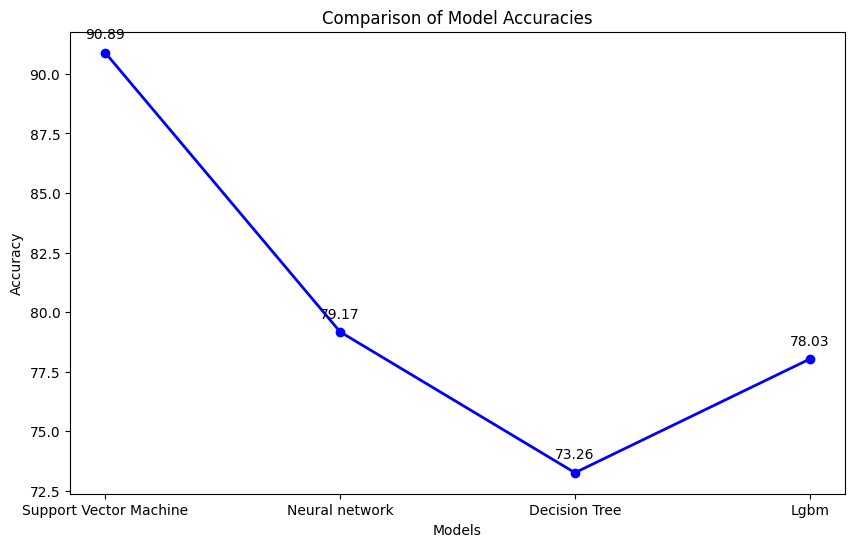

In [ ]:
# Creating the line chart
plt.figure(figsize=(10, 6))
plt.plot(model_names, model_accuracies, marker='o', color='b', linestyle='-', linewidth=2)

# Adding accuracy values above each point
for i, txt in enumerate(model_accuracies):
    plt.annotate(f"{txt:.2f}", (model_names[i], model_accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Adding title and labels
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Display the plot
plt.show()